In [1]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import time
from scipy.signal import savgol_filter
from scipy.io import loadmat
import re
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
import open3d as o3
%matplotlib qt5

In [2]:
def matlab_timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromordinal(int(i) - 366) + timedelta(days=i%1) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True,max_distance=8):
    # WINDOW_SIZE=500
    # max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('_metadata.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = len(frames[master])
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    N = len(frames[master])
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search<=min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)


def get_timestamps(virmendir, realsensedir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    timestamps['virmen'] = matlab_timestamp_to_numpy(data['timeStamp'])
    
    files = os.listdir(realsensedir)
    files.sort()
    
    eye_datafile = [os.path.join(realsensedir, i) for i in files if 'eyeData.mat' in i][0]
    eyedata = loadmat(eye_datafile, squeeze_me=True)
    timestamps['eye'] = matlab_timestamp_to_numpy(np.array([i[0] for i in eyedata['data']]))
    
    filelist = {os.path.basename(i)[:-3]:os.path.join(datadir, i) for i in files if i.endswith('t.h5')}
    for cam, file in filelist.items():
        if not file.endswith('_metadata.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
        timestamps[cam] = timestamp
    return(timestamps)

def align_signals_by_timestamps(timestamps, master='virmen',use_window=True,WINDOW_SIZE=1000,max_distance=7):
    assert(type(timestamps)==dict)
    assert(master in timestamps.keys())
    
    N = len(timestamps[master])
    keys = timestamps.keys()
    
    offsets = {}
    t0 = timestamps[master][0]
    for key in keys:
        if key != master:
            offsets[key] = np.abs(timestamps[key] - t0).argmin()
    # LUT = np.zeros()
    LUT = np.zeros((N,len(timestamps)-1), dtype=np.float64)
    timestamp_matrix = np.zeros((N,len(timestamps)-1), dtype='datetime64[us]')
    j=-1
    original_window = WINDOW_SIZE
    for key,offset in offsets.items():
        j+=1
        WINDOW_SIZE = original_window
        for i in range(0,N):
            t = timestamps[master][i]
            
            min_search = max(0, i+offset-WINDOW_SIZE)
            max_search = min(len(timestamps[key]), i+offset+WINDOW_SIZE)
            
            if max_search <=min_search:
                LUT[i,j] = np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[key][min_search:max_search]-t).astype(np.float64)/1000)
            else:
                snippet = np.abs((timestamps[key]-t).astype(np.float64)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            if mint < max_distance:
                LUT_val = argmin + min_search
                nearest_timestamp = timestamps[key][argmin+min_search]
            else:
                LUT_val = np.nan
                nearest_timestamp = np.datetime64('NaT')
                WINDOW_SIZE+=1
            LUT[i,j] = LUT_val
            timestamp_matrix[i,j] = nearest_timestamp
    LUT = np.hstack((np.arange(0,N)[...,np.newaxis], LUT))
    # data = np.hstack((camera_LUT, timestamps[master]))
    LUT = pd.DataFrame(LUT, columns=[master]+list(offsets.keys()))
    
    timestamp_matrix = np.hstack((timestamps[master][...,np.newaxis], timestamp_matrix))
    timestamp_matrix = pd.DataFrame(timestamp_matrix, columns=[master]+list(offsets.keys()))
    #     df[master] = timestamps[master]
    # df['timestamps'] = timestamps[master]
    
    return(LUT, timestamp_matrix)

def get_virmen_iterdata(virmendir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    return(data)

def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(480,640)):
    lefts = {}
    rights = {}
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts[camname] = left
        # lefts.append(left)
        rights[camname] = right
        # rights.append(right)
    return(lefts, rights)

# Calibrate!!!

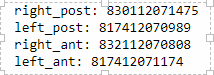

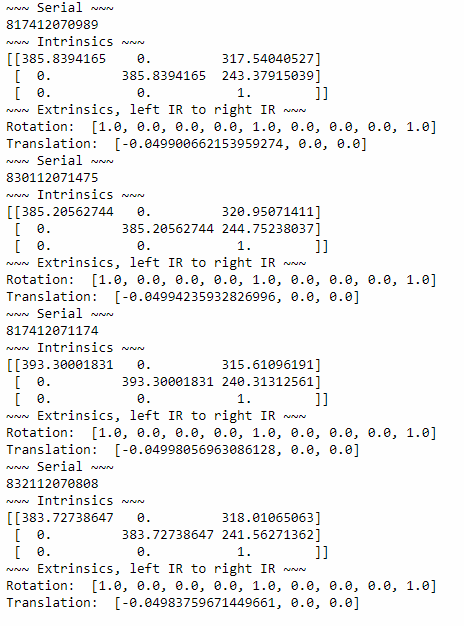

In [3]:
intrinsics = {}
intrinsics['left_post'] = np.array([[385.8394165, 0, 317.54],[0,385.839,243.379],[0,0,1]])
intrinsics['right_post'] = np.array([[385.2056, 0, 320.9507],[0,385.2056,244.7523],[0,0,1]])
intrinsics['left_ant']  = np.array([[393.30001, 0, 315.6109],[0,393.30001,240.3131],[0,0,1]])
intrinsics['right_ant'] = np.array([[383.727, 0, 318.0106],[0,383.727,241.5627],[0,0,1]])

extrinsics = {}
extrinsics['left_post'] = np.hstack((np.eye(3,3), np.array([-0.04990066,0,0])[...,np.newaxis]))
extrinsics['right_post'] = np.hstack((np.eye(3,3), np.array([-0.04994235,0,0])[...,np.newaxis]))
extrinsics['left_ant'] = np.hstack((np.eye(3,3), np.array([-0.04998056,0,0])[...,np.newaxis]))
extrinsics['right_ant'] = np.hstack((np.eye(3,3), np.array([-0.04983759,0,0])[...,np.newaxis]))

P_l = {}
P_r = {}
for camname in list(extrinsics.keys()):
    this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l[camname] = np.dot(intrinsics[camname], this_P_l)
    P_r[camname] = np.dot(intrinsics[camname], extrinsics[camname])
print(extrinsics)

{'left_post': array([[ 1.        ,  0.        ,  0.        , -0.04990066],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'right_post': array([[ 1.        ,  0.        ,  0.        , -0.04994235],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'left_ant': array([[ 1.        ,  0.        ,  0.        , -0.04998056],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'right_ant': array([[ 1.        ,  0.        ,  0.        , -0.04983759],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])}


In [4]:
calibdir = r'/media/jim/FASTER/realsense/calibration_60hz_190507_115348/'
files = os.listdir(calibdir)
files.sort()

camnames = ['left_ant', 'left_post', 'right_ant', 'right_post']
calibfiles = {}
calibims = {camname:[] for camname in camnames}
pattern = re.compile('\d{4}.bmp$')
for camname in camnames:
    for file in files:
        if '.h5' in file and camname in file:
            calibfiles[camname] = os.path.join(calibdir,file)
            
imdir = os.path.join(calibdir, 'images')
files = os.listdir(imdir)
files.sort()
for camname in camnames:
    for file in files:
        match = pattern.search(file)
        if match and camname in file:
            fullfile = os.path.join(imdir, file)
            calibims[camname].append(fullfile)
            assert(os.path.isfile(fullfile))
# calibfiles = {camname:os.path.join(calibdir, i) for camname, i in zip(camnames,calibfiles) 
#               if i==camname +'_metadata.h5'}
print(calibfiles)

{'left_ant': '/media/jim/FASTER/realsense/calibration_60hz_190507_115348/left_ant_metadata.h5', 'left_post': '/media/jim/FASTER/realsense/calibration_60hz_190507_115348/left_post_metadata.h5', 'right_ant': '/media/jim/FASTER/realsense/calibration_60hz_190507_115348/right_ant_metadata.h5', 'right_post': '/media/jim/FASTER/realsense/calibration_60hz_190507_115348/right_post_metadata.h5'}


In [ ]:
# OPTIONAL: move files over!!
# import shutil
# contents = os.listdir(datadir)
# contents.sort()
# imdir = os.path.join(datadir, 'images')
# if not os.path.isdir(imdir):
#     os.makedirs(imdir)
# images = [os.path.join(datadir, i) for i in contents if i.endswith('.bmp')]
# for i in tqdm(range(len(images))):
#     src = images[i]
#     dst = os.path.join(imdir, os.path.basename(src))
#     shutil.move(src,dst)

In [5]:
np.set_printoptions(suppress=True)

In [6]:
LUT = align_cameras_on_timestamps(calibfiles, max_distance=20,WINDOW_SIZE=10000, use_window=False)

## Verify image and corner quality

In [7]:
def get_frames_by_index_uncompressed(calibims, LUT, index):
    camnames = list(calibims.keys())
    lefts = {}
    rights = {}
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, filelist in calibims.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            im = cv2.imread(filelist[camind],0)
            H,W = im.shape
            left = im[:,:W//2]
            right = im[:, W//2:]
        else:
            left, right = None,None
        lefts[camname] = left
        rights[camname] = right
        # lefts.append(left)
        # rights.append(right)
    return(lefts,rights)

In [8]:
def find_corners_in_image(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 0, 0.00001)
    chessboard_columns=9
    chessboard_rows=6
    square_size_mm=6

    ret, corners = cv2.findChessboardCorners(img, (chessboard_rows, chessboard_columns))
    if ret:
        # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 0,.00001)
        corners = cv2.cornerSubPix(img,corners,(5,5),(-1,-1),criteria)
        return(corners)
    else:
        return(None)

In [9]:
def plot_corners(corners, ax=None, text=True,cmap='viridis', **kwargs):
    if corners is None:
        return
    if ax is None:
        ax = plt.gca()
    if type(corners) != np.ndarray:
        raise ValueError('invalid inputs!')
    if corners.shape[0] == 2:
        corners = corners.T
    # print(corners.shape)
    
    x = corners.squeeze()[:,0]
    y = corners.squeeze()[:,1]
    inds = np.arange(len(x))
    cmap = plt.get_cmap('viridis')
    
    if text:
        for i in inds:
            ax.text(x[i],y[i],s=str(i), 
                   color=cmap(i/len(inds)))
    else:
        ax.plot(x,y,'rx', **kwargs)
    

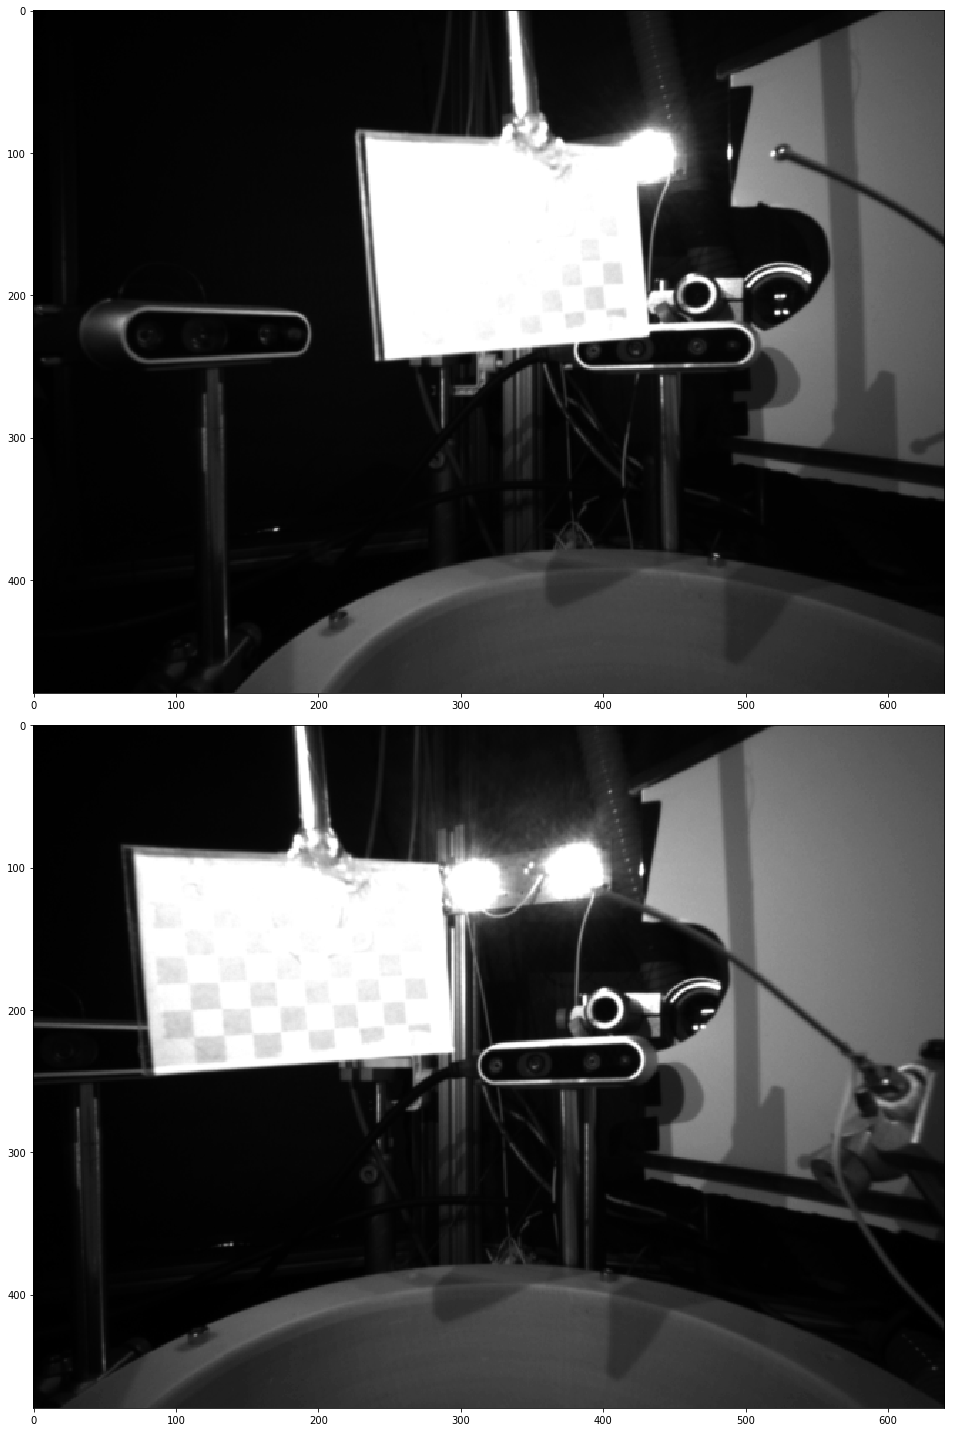

In [14]:
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, np.random.randint(low=0,high=len(LUT)))

fig, ax = plt.subplots(2,1,figsize=(16,20))
# fig.clear()
# camind = np.random.randint(low=0,high=len(rights))
cams = list(lefts.keys())
cam = cams[np.random.randint(low=0,high=len(lefts))]
im = lefts[cam]
rim = rights[cam]

ax[0].imshow(im, 'gray')
corners = find_corners_in_image(im)
if corners is not None:
    x = corners[:,:,0]
    y = corners[:,:,1]
    plot_corners(corners, ax[0], text=False)
    
ax[1].imshow(rim, 'gray')
corners = find_corners_in_image(rim)
if corners is not None:
    x = corners[:,:,0]
    y = corners[:,:,1]
    plot_corners(corners, ax[1], text=False)
# ax.plot(x, y, 'ro',markersize=2.5, alpha=0.5)


plt.tight_layout()
plt.show()

## Get corners from every image in the directory

In [47]:
def get_corners_and_names(calibims, LUT, index):
    filenames = get_filenames_by_index(calibims, LUT, index)
    corners = get_corners_by_row(calibims, LUT, index)
    return(filenames, corners)

def append_corners_to_file(calibims, LUT, index, h5file):
    filenames = get_filenames_by_index(calibims, LUT, index)
    corners = get_corners_by_row(calibims, LUT, index)
    
    camnames = list(calibims.keys())
    
    # print(list(h5file.keys()))
    for cam in camnames:
        h5file[cam + '/imfiles'][index] = filenames[cam]
        # print(corners[cam + '_l'].shape)
        h5file[cam + '/corners/l'][index] = corners[cam + '_l'].flatten()
        h5file[cam + '/corners/r'][index] = corners[cam + '_r'].flatten()
        
def get_filenames_by_index(calibims, LUT, index):
    camnames = list(calibims.keys())
    names = {}
    # rights = []
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, filelist in calibims.items():
        camind = row[camname]
        if not np.isnan(camind):
            name = filelist[int(camind)]
        else:
            name = None
        names[camname] = name
    return(names)

def get_corners_by_row(calibims, LUT, i):
    lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, i)
    this_dict = {}
    # print(len(camnames))
    # print(len(lefts))
    nan = np.array((np.nan,)).astype(np.float32)
    for camname in camnames:
        left = lefts[camname]
        right = rights[camname]
        if left is not None:
            corners_l = find_corners_in_image(left)
            this_dict[camname+'_l'] = corners_l if corners_l is not None else nan
        else:
            this_dict[camname+'_l'] = nan
            
        if right is not None:
            corners_r = find_corners_in_image(right)
            this_dict[camname+'_r'] = corners_r if corners_r is not None else nan
        else:
            this_dict[camname+'_r'] = nan
        
    return(this_dict)

In [62]:
def write_corners_to_file(camnames, calibdir, LUT, num_workers=16, shape=[54,1,2]):
    
    files = os.listdir(calibdir)
    files.sort()
    if 'images' in files:
        imdir = os.path.join(calibdir, 'images')
        imfiles = os.listdir(imdir)
        imfiles.sort()
    else:
        imdir = calibdir
        imfiles = files
        
    calibfiles = {}
    calibims = {camname:[] for camname in camnames}
    pattern = re.compile('\d{4}.bmp$')
    for camname in camnames:
        for file in imfiles:
            match = pattern.search(file)
            if match and camname in file:
                fullfile = os.path.join(imdir, file)
                calibims[camname].append(fullfile)
                assert(os.path.isfile(fullfile))
    
    cornerfile = os.path.join(calibdir, 'corners.h5')
    N = len(LUT)
    # camnames = list(calibims.keys())
    
    with h5py.File(cornerfile, 'w') as f:
        floattype = h5py.special_dtype(vlen=np.dtype('float32'))
        strtype = h5py.special_dtype(vlen=str)

        for cam in camnames:
            group = f.create_group(cam)

            ds = group.create_dataset('imfiles', (N,), dtype=strtype)
            # ds = subgrp.create_dataset('l',
            # ds = subgrp.create_dataset('r', (N,), dtype=strtype)

            subgrp = group.create_group('corners')
            ds = subgrp.create_dataset('l', (N,), dtype=floattype)
            ds = subgrp.create_dataset('r', (N,), dtype=floattype)
        f['shape'] = shape
        # f[cam + '/corners/l'][0] = np.array((np.nan,)).astype(np.float32)
        # append_corners_to_file(calibims, LUT, 100, f)
        tuples = [(calibims, LUT, i) for i in range(N)]
        with mp.Pool(num_workers) as pool:
            res = pool.starmap(get_corners_and_names, tuples)
            
        for cam in camnames:
            for index in range(N):
                filenames, corners = res[index]

                f[cam + '/imfiles'][index] = filenames[cam]
                # print(corners[cam + '_l'].shape)
                f[cam + '/corners/l'][index] = corners[cam + '_l'].flatten()
                f[cam + '/corners/r'][index] = corners[cam + '_r'].flatten()

In [59]:
calibdir = r'/media/jim/FASTER/realsense/calibration_60hz_190507_115348'

In [60]:
camnames = ['left_ant', 'left_post', 'right_ant', 'right_post']

cornerfile = os.path.join(calibdir, 'corners.h5')
if os.path.isfile(cornerfile):
    print('Corners already computed!')
else:
    write_corners_to_file(camnames,calibdir, LUT)

Corners already computed!


In [63]:
write_corners_to_file(camnames,calibdir, LUT)

In [72]:
def get_corners_from_file(calibdir, index):
    h5file = os.path.join(calibdir, 'corners.h5')
    corners = {}
    with h5py.File(h5file, 'r') as f:
        shape = f['shape'][:]
        camnames = [i for i in list(f.keys()) if 'left' in i or 'right' in i]
        # print(camnames)
        for cam in camnames:
            # import pdb
            # pdb.set_trace()
            corner = f[cam + '/corners/l'][index]
            if len(corner) > 1:
                corner = corner.reshape(shape)
            else:
                corner = None
            corners[cam + '_l'] = corner
            
            corner =  f[cam + '/corners/r'][index]
            if len(corner) > 1:
                corner = corner.reshape(shape)
            else:
                corner = None
            corners[cam + '_r'] = corner
            # corners[cam + '_r'] = f[cam + '/corners/r'][index].reshape(shape)
    return(corners)

def get_images_and_corners(calibdir, calibims, LUT, index):
    lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, index)
    corners = get_corners_from_file(calibdir, index)
    return(lefts, rights, corners)

def get_valid_camera_pairs(calibdir, cams):
    h5file = os.path.join(calibdir, 'corners.h5')
    with h5py.File(h5file, 'r') as f:
        N = f[cams[0] + '/corners/l'].shape[0]

        all_valid = np.zeros((N,len(cams)), dtype=np.uint8)
        for i in range(len(cams)):
            l = f[cams[i] + '/corners/l'][:]
            r = f[cams[i] + '/corners/r'][:]
            has_corners =  np.array([0 if np.any(np.isnan(i)) or np.any(np.isnan(j)) else 1 for i,j in zip(l,r)])
            all_valid[:,i] = has_corners
    valid_indices = np.where(all_valid.sum(axis=1)==len(cams))[0]
    return(valid_indices)
        

### for each pair of cameras, find the images that have corners for all 4 images

In [73]:
cams = ['right_post', 'left_post']

caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
    

In [74]:
valid_indices = get_valid_camera_pairs(calibdir,  cams)

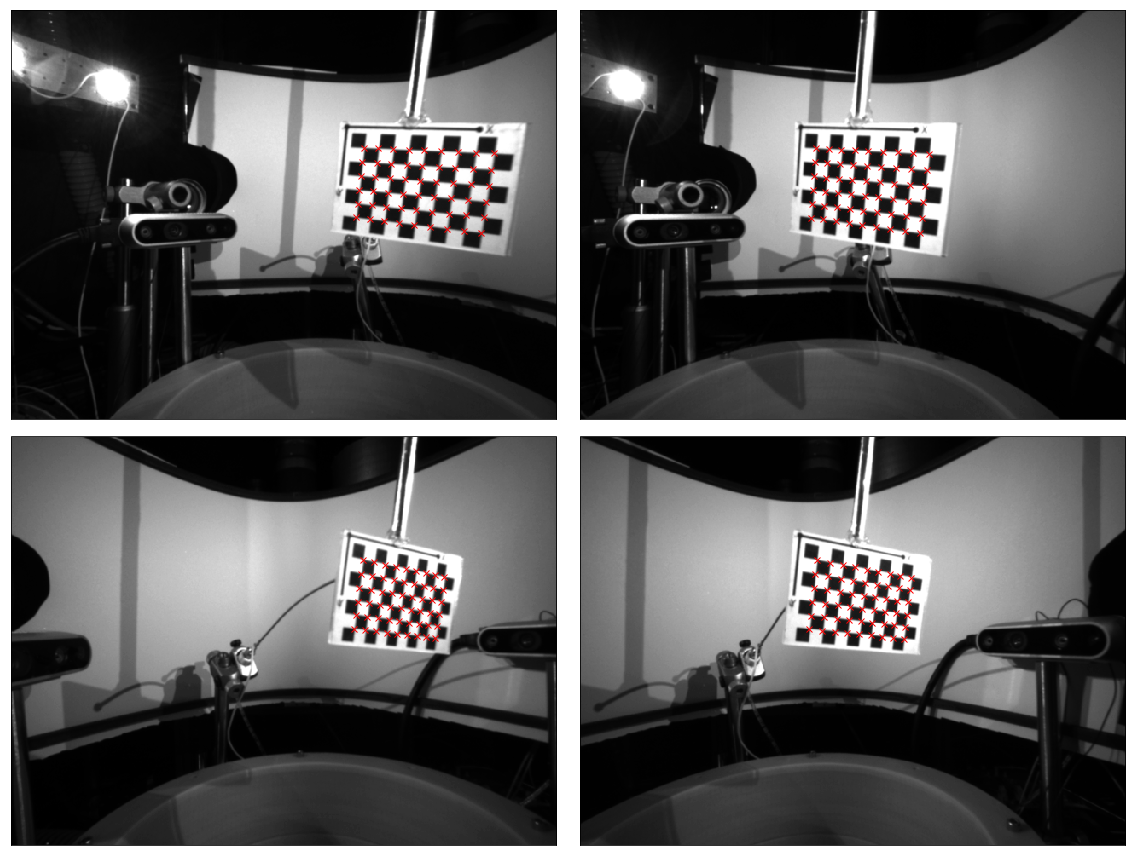

In [76]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]

lefts, rights, corners = get_images_and_corners(calibdir, calibims, LUT, ind)
# corners = all_corners[ind]
# lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

plot_text = False

fig, ax = plt.subplots(2,2,figsize=(16,12))
im = lefts[cams[0]]
ax[0,0].imshow(im, 'gray')
plot_corners(l1, ax[0,0], text=plot_text)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[0]]
ax[0,1].imshow(im, 'gray')
plot_corners(r1, ax[0,1], text=plot_text)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

im = lefts[cams[1]]
ax[1,0].imshow(im, 'gray')
plot_corners(l2, ax[1,0], text=plot_text)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[1]]
ax[1,1].imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax[1,1], text=plot_text)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [77]:
def triangulate(P_l, P_r, leftpoints, rightpoints):
    points4d = cv2.triangulatePoints(P_l, P_r, leftpoints, rightpoints)
    return(points4d)

In [78]:
def reproject_points(points4d, projection_matrix):
    # points4d = cv2.triangulatePoints(P_l, P_r, leftpoints, rightpoints)
    reprojected = np.dot(projection_matrix, points4d).T
    reprojected= reprojected[:,0:2]/reprojected[:,2:]
    return(reprojected)

In [79]:
import math
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    # assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

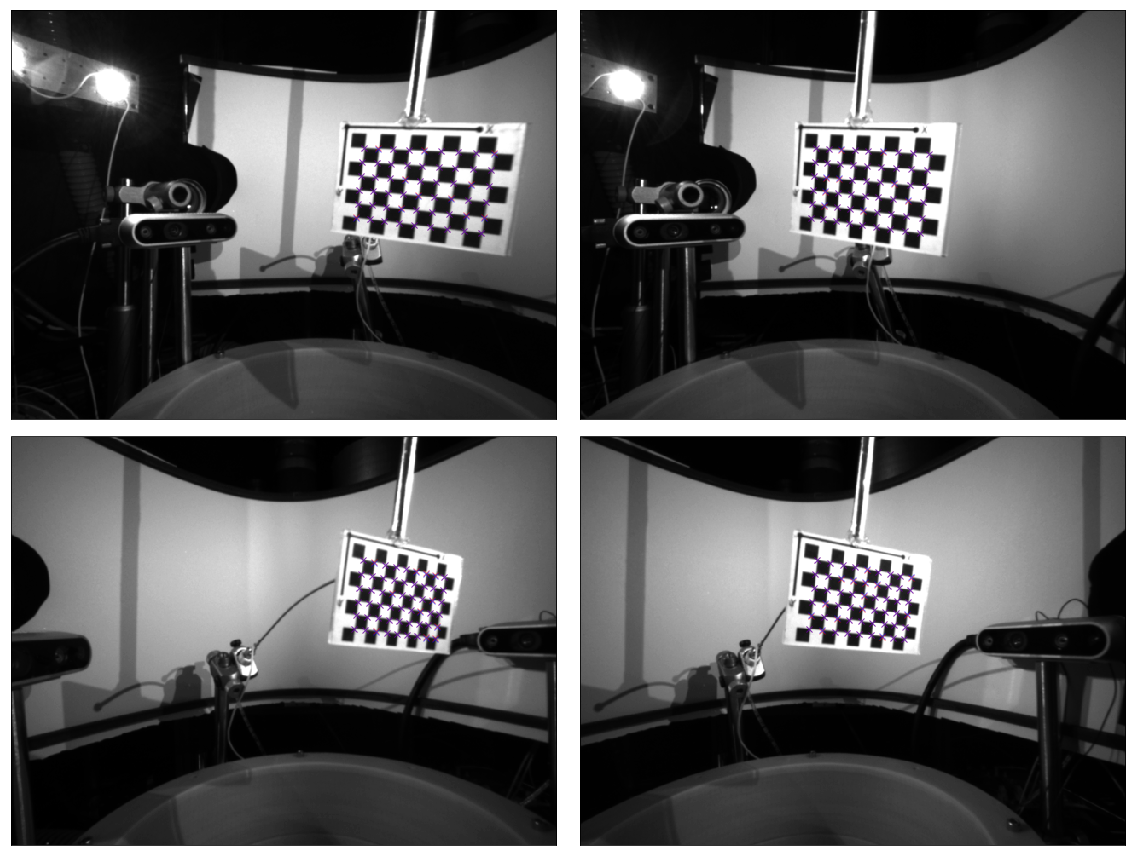

In [82]:
# ind = all_there[np.random.randint(low=0,high=len(all_there))]

# corners = all_corners[ind]
# lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)
l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
left_4d = cv2.triangulatePoints(P_l[cams[0]], P_r[cams[0]], l1, r1)
l1_reprojected = np.dot(P_l[cams[0]], left_4d).T
l1_reprojected= l1_reprojected[:,0:2]/l1_reprojected[:,2:]


fig, ax = plt.subplots(2,2,figsize=(16,12))

points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
l1_reprojected = reproject_points(points4d, P_l[cams[0]])
r1_reprojected = reproject_points(points4d, P_r[cams[0]])
im = lefts[cams[0]]
ax[0,0].imshow(im, 'gray')
plot_corners(l1, ax[0,0],text=False, alpha=0.5, color='r')
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(l1_reprojected, ax[0,0],text=False,alpha=0.5, color='b')
# ax[0,0].plot(l1_reprojected[:,0], l1_reprojected[:,1], color='b',markersize=2.5, alpha=0.5)

im = rights[cams[0]]
ax[0,1].imshow(im, 'gray')
plot_corners(r1, ax[0,1],text=False, alpha=0.5, color='r')
plot_corners(r1_reprojected, ax[0,1],text=False,alpha=0.5, color='b')

points4d = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
l2_reprojected = reproject_points(points4d, P_l[cams[1]])
r2_reprojected = reproject_points(points4d, P_r[cams[1]])
im = lefts[cams[1]]
ax[1,0].imshow(im, 'gray')
plot_corners(l2, ax[1,0], text=False,alpha=0.5, color='r')
plot_corners(l2_reprojected, ax[1,0], text=False,alpha=0.5, color='b')
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# ax[1,0].plot(l2_reprojected[:,0], l2_reprojected[:,1], 'bo',markersize=2.5, alpha=0.5)

im = rights[cams[1]]
ax[1,1].imshow(im, 'gray')
plot_corners(r2, ax[1,1], text=False,alpha=0.5, color='r')
plot_corners(r2_reprojected, ax[1,1], text=False,alpha=0.5, color='b')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# ax[1,1].plot(r2_reprojected[:,0], r2_reprojected[:,1], 'bo',markersize=2.5, alpha=0.5)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

In [83]:
def numpy_to_pcd(array):
    pcd = o3.PointCloud()
    try:
        pcd.points= o3.Vector3dVector(array)
    except RuntimeError:
        print('Error, transposing...')
        pcd.points= o3.Vector3dVector(array.T)
    return(pcd)

In [84]:
points4d_l = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_r = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

In [85]:
pcd_l = numpy_to_pcd(points4d_l[0:3,:]/points4d_l[3,:])
pcd_r = numpy_to_pcd(points4d_r[0:3,:]/points4d_r[3,:])
o3.draw_geometries([pcd_l, pcd_r])

Error, transposing...
Error, transposing...


In [86]:
leftpoints = []
rightpoints = []

for ind in valid_indices:
    corners = get_corners_from_file(calibdir, ind)
    # corners = all_corners[ind]
    # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
    points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    leftpoint = points4d[0:3,:]/points4d[3,:]
    points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
    rightpoint = points4d[0:3,:]/points4d[3,:]
    leftpoints.append(leftpoint)
    rightpoints.append(rightpoint)
    
leftpoints = np.hstack(leftpoints).T
rightpoints = np.hstack(rightpoints).T

In [87]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(leftpoints)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(rightpoints)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

In [88]:
import numpy as np
import re


# Python 2/3 compatibility
# Make range a iterator in Python 2
try:
    range = xrange
except NameError:
    pass


def kabsch_rmsd(P, Q):
    """
    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        root-mean squared deviation
    """
    P = kabsch_rotate(P, Q)
    return rmsd(P, Q)


def kabsch_rotate(P, Q):
    """
    Rotate matrix P unto matrix Q using Kabsch algorithm.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    P : array
        (N,D) matrix, where N is points and D is dimension,
        rotated
    """
    U = kabsch(P, Q)

    # Rotate P
    P = np.dot(P, U)
    return P


def kabsch(P, Q):
    """
    The optimal rotation matrix U is calculated and then used to rotate matrix
    P unto matrix Q so the minimum root-mean-square deviation (RMSD) can be
    calculated.
    Using the Kabsch algorithm with two sets of paired point P and Q, centered
    around the centroid. Each vector set is represented as an NxD
    matrix, where D is the the dimension of the space.
    The algorithm works in three steps:
    - a translation of P and Q
    - the computation of a covariance matrix C
    - computation of the optimal rotation matrix U
    http://en.wikipedia.org/wiki/Kabsch_algorithm
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    U : matrix
        Rotation matrix (D,D)
    Example
    -----
    TODO
    """

    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U


def quaternion_rmsd(P, Q):
    """
    Rotate matrix P unto Q and calculate the RMSD
    based on doi:10.1016/1049-9660(91)90036-O
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
    """
    rot = quaternion_rotate(P, Q)
    P = np.dot(P, rot)
    return rmsd(P, Q)


def quaternion_transform(r):
    """
    Get optimal rotation
    note: translation will be zero when the centroids of each molecule are the
    same
    """
    Wt_r = makeW(*r).T
    Q_r = makeQ(*r)
    rot = Wt_r.dot(Q_r)[:3, :3]
    return rot


def makeW(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    W = np.asarray([
             [r4, r3, -r2, r1],
             [-r3, r4, r1, r2],
             [r2, -r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return W


def makeQ(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    Q = np.asarray([
             [r4, -r3, r2, r1],
             [r3, r4, -r1, r2],
             [-r2, r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return Q


def quaternion_rotate(X, Y):
    """
    Calculate the rotation
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Y: array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rot : matrix
        Rotation matrix (D,D)
    """
    N = X.shape[0]
    W = np.asarray([makeW(*Y[k]) for k in range(N)])
    Q = np.asarray([makeQ(*X[k]) for k in range(N)])
    Qt_dot_W = np.asarray([np.dot(Q[k].T, W[k]) for k in range(N)])
    W_minus_Q = np.asarray([W[k] - Q[k] for k in range(N)])
    A = np.sum(Qt_dot_W, axis=0)
    eigen = np.linalg.eigh(A)
    r = eigen[1][:, eigen[0].argmax()]
    rot = quaternion_transform(r)
    return rot


def centroid(X):
    """
    Calculate the centroid from a vectorset X.
    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.
    C = sum(X)/len(X)
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    C : float
        centeroid
    """
    C = X.mean(axis=0)
    return C


def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation
    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)


def write_coordinates(atoms, V, title=""):
    """
    Print coordinates V with corresponding atoms to stdout in XYZ format.
    Parameters
    ----------
    atoms : list
        List of atomic types
    V : array
        (N,3) matrix of atomic coordinates
    title : string (optional)
        Title of molecule
    """
    N, D = V.shape

    print(str(N))
    print(title)

    for i in range(N):
        atom = atoms[i]
        atom = atom[0].upper() + atom[1:]
        print("{0:2s} {1:15.8f} {2:15.8f} {3:15.8f}".format(
                atom, V[i, 0], V[i, 1], V[i, 2]))


def get_coordinates(filename, fmt):
    """
    Get coordinates from filename in format fmt. Supports XYZ and PDB.
    Parameters
    ----------
    filename : string
        Filename to read
    fmt : string
        Format of filename. Either xyz or pdb.
    Returns
    -------
    atoms : list
        List of atomic types
    V : array
        (N,3) where N is number of atoms
    """
    if fmt == "xyz":
        return get_coordinates_xyz(filename)
    elif fmt == "pdb":
        return get_coordinates_pdb(filename)
    exit("Could not recognize file format: {:s}".format(fmt))


def get_coordinates_pdb(filename):
    """
    Get coordinates from the first chain in a pdb file
    and return a vectorset with all the coordinates.
    Parameters
    ----------
    filename : string
        Filename to read
    Returns
    -------
    atoms : list
        List of atomic types
    V : array
        (N,3) where N is number of atoms
    """
    # PDB files tend to be a bit of a mess. The x, y and z coordinates
    # are supposed to be in column 31-38, 39-46 and 47-54, but this is
    # not always the case.
    # Because of this the three first columns containing a decimal is used.
    # Since the format doesn't require a space between columns, we use the
    # above column indices as a fallback.
    x_column = None
    V = list()
    # Same with atoms and atom naming.
    # The most robust way to do this is probably
    # to assume that the atomtype is given in column 3.
    atoms = list()

    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("TER") or line.startswith("END"):
                break
            if line.startswith("ATOM"):
                tokens = line.split()
                # Try to get the atomtype
                try:
                    atom = tokens[2][0]
                    if atom in ("H", "C", "N", "O", "S", "P"):
                        atoms.append(atom)
                    else:
                        # e.g. 1HD1
                        atom = tokens[2][1]
                        if atom == "H":
                            atoms.append(atom)
                        else:
                            raise Exception
                except:
                        exit("Error parsing atomtype for the following line: \n{0:s}".format(line))

                if x_column == None:
                    try:
                        # look for x column
                        for i, x in enumerate(tokens):
                            if "." in x and "." in tokens[i + 1] and "." in tokens[i + 2]:
                                x_column = i
                                break
                    except IndexError:
                        exit("Error parsing coordinates for the following line: \n{0:s}".format(line))
                # Try to read the coordinates
                try:
                    V.append(np.asarray(tokens[x_column:x_column + 3], dtype=float))
                except:
                    # If that doesn't work, use hardcoded indices
                    try:
                        x = line[30:38]
                        y = line[38:46]
                        z = line[46:54]
                        V.append(np.asarray([x, y ,z], dtype=float))
                    except:
                        exit("Error parsing input for the following line: \n{0:s}".format(line))


    V = np.asarray(V)
    atoms = np.asarray(atoms)
    assert(V.shape[0] == atoms.size)
    return atoms, V


def get_coordinates_xyz(filename):
    """
    Get coordinates from filename and return a vectorset with all the
    coordinates, in XYZ format.
    Parameters
    ----------
    filename : string
        Filename to read
    Returns
    -------
    atoms : list
        List of atomic types
    V : array
        (N,3) where N is number of atoms
    """

    f = open(filename, 'r')
    V = list()
    atoms = list()
    n_atoms = 0

    # Read the first line to obtain the number of atoms to read
    try:
        n_atoms = int(f.readline())
    except ValueError:
        exit("Could not obtain the number of atoms in the .xyz file.")

    # Skip the title line
    f.readline()

    # Use the number of atoms to not read beyond the end of a file
    for lines_read, line in enumerate(f):

        if lines_read == n_atoms:
            break

        atom = re.findall(r'[a-zA-Z]+', line)[0]
        atom = atom.upper()

        numbers = re.findall(r'[-]?\d+\.\d*(?:[Ee][-\+]\d+)?', line)
        numbers = [float(number) for number in numbers]

        # The numbers are not valid unless we obtain exacly three
        if len(numbers) == 3:
            V.append(np.array(numbers))
            atoms.append(atom)
        else:
            exit("Reading the .xyz file failed in line {0}. Please check the format.".format(lines_read + 2))

    f.close()
    atoms = np.array(atoms)
    V = np.array(V)
    return atoms, V

In [89]:
def calculate_transformation_kabsch(src_points, dst_points):
    """
    Calculates the optimal rigid transformation from src_points to
    dst_points
    (regarding the least squares error)
    Parameters:
    -----------
    src_points: array
        (3,N) matrix
    dst_points: array
        (3,N) matrix

    Returns:
    -----------
    rotation_matrix: array
        (3,3) matrix

    translation_vector: array
        (3,1) matrix
    rmsd_value: float
    """
    assert src_points.shape == dst_points.shape
    if src_points.shape[0] != 3:
        raise Exception("The input data matrix had to be transposed in order to compute transformation.")

    src_points = src_points.transpose()
    dst_points = dst_points.transpose()

    src_points_centered = src_points - centroid(src_points)
    dst_points_centered = dst_points - centroid(dst_points)

    rotation_matrix = kabsch(src_points_centered, dst_points_centered)
    rmsd_value = kabsch_rmsd(src_points_centered, dst_points_centered)

    translation_vector = centroid(dst_points) - np.matmul(centroid(src_points), rotation_matrix)

    return rotation_matrix.transpose(), translation_vector.transpose(), rmsd_value

In [90]:
leftpoints.shape

(25434, 3)

In [91]:
R, t, quality = calculate_transformation_kabsch(rightpoints.T, leftpoints.T)
print(rotationMatrixToEulerAngles(R)*180/math.pi)
print(t)

[ 0.00934918 44.42509842  2.77449182]
[-0.09265105  0.00014865  0.0632409 ]


In [92]:
right_in_left = R@rightpoints.T + t[...,np.newaxis]

In [93]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(leftpoints)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right_in_left.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

In [94]:
R

array([[ 0.71332896, -0.04829104,  0.6991637 ],
       [ 0.03456928,  0.9988333 ,  0.03371946],
       [-0.6999762 ,  0.00011653,  0.7141661 ]], dtype=float32)

In [95]:
np.hstack((R,t[...,None]))

array([[ 0.71332896, -0.04829104,  0.6991637 , -0.09265105],
       [ 0.03456928,  0.9988333 ,  0.03371946,  0.00014865],
       [-0.6999762 ,  0.00011653,  0.7141661 ,  0.0632409 ]],
      dtype=float32)

In [96]:
trans_init = np.vstack((np.hstack((R,t[...,None])), [0.,0.,0.,1.]))
print(trans_init)

[[ 0.71332896 -0.04829104  0.69916368 -0.09265105]
 [ 0.03456928  0.9988333   0.03371946  0.00014865]
 [-0.69997621  0.00011653  0.7141661   0.0632409 ]
 [ 0.          0.          0.          1.        ]]


In [97]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0, 1])
    source_temp.transform(transformation)
    o3.draw_geometries([source_temp, target_temp])

In [98]:
# source = 
# trans_init = np.eye(4)
reg_p2p = o3.registration_icp(numpy_to_pcd(rightpoints),
                              numpy_to_pcd(leftpoints), 0.11, trans_init,
            o3.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000279, and correspondence_set size of 25434
Access transformation to get result.
Transformation is:
[[ 0.71319186 -0.04834582  0.69929973 -0.09266503]
 [ 0.03454992  0.99883065  0.03381748  0.0001328 ]
 [-0.70011684  0.00004241  0.71402824  0.06327186]
 [ 0.          0.          0.          1.        ]]


In [99]:
matrix = reg_p2p.transformation
R,t = matrix[:3,:3], matrix[:3,3]
print(rotationMatrixToEulerAngles(R)*180/math.pi)

[ 0.00340341 44.43638111  2.77347281]


In [100]:
reg_p2p = o3.registration_icp(numpy_to_pcd(rightpoints),
                              numpy_to_pcd(leftpoints), 0.1, np.eye(4),
            o3.TransformationEstimationPointToPlane())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

registration::RegistrationResult with fitness = 0.000000, inlier_rmse = 0.000000, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [101]:
rightpoints

array([[ 0.01217813, -0.02007131,  0.08577596],
       [ 0.01245401, -0.02605331,  0.0853849 ],
       [ 0.01274498, -0.03206745,  0.08499216],
       ...,
       [ 0.08123874, -0.02879536,  0.1308077 ],
       [ 0.08097354, -0.03478992,  0.13047622],
       [ 0.08073907, -0.04079586,  0.13014638]], dtype=float32)

In [102]:
right = numpy_to_pcd(rightpoints)
o3.estimate_normals(right, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
right_feats = o3.compute_fpfh_feature(right,
            o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))

left = numpy_to_pcd(leftpoints)
o3.estimate_normals(left, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
left_feats = o3.compute_fpfh_feature(right,
            o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))

In [103]:
np.set_printoptions(suppress=True, precision=6)

In [104]:
distance_threshold=0.01
edge_length = 0.1
result = o3.registration_ransac_based_on_feature_matching(
            right, left, right_feats, left_feats,
            distance_threshold,
            o3.TransformationEstimationPointToPoint(True), 4,
            [o3.CorrespondenceCheckerBasedOnEdgeLength(edge_length),
            o3.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3.RANSACConvergenceCriteria(4000000, 5000))

In [105]:
print(result)
print(result.transformation)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000279, and correspondence_set size of 25434
Access transformation to get result.
[[ 0.713562 -0.048338  0.699635 -0.092726]
 [ 0.034526  0.99933   0.033831  0.000133]
 [-0.700453  0.000015  0.714397  0.063233]
 [ 0.        0.        0.        1.      ]]


In [106]:
R = result.transformation[:3,:3]
t = result.transformation[:3,3]
print(rotationMatrixToEulerAngles(R)*180/math.pi)

[ 0.001227 44.435334  2.770146]


In [107]:
right_in_left = R@rightpoints.T + t[...,np.newaxis]

In [108]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(leftpoints)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right_in_left.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

# try randomly sampling checkerboards

In [109]:
# FOR RANDOM SAMPLING
num_checkerboards = 10
inds = np.random.choice(valid_indices, size=(num_checkerboards,))
print(inds)
print(cams[0], cams[1])

[ 457  449  578 1175 1294  387  470  485  449  473]
right_post left_post


In [110]:
# FOR ALL IMAGES
inds = valid_indices

In [111]:
leftpoints = []
rightpoints = []

for ind in inds:
    corners = get_corners_from_file(calibdir, ind)
    # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
    points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    leftpoint = points4d[0:3,:]/points4d[3,:]
    points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
    rightpoint = points4d[0:3,:]/points4d[3,:]
    
    leftpoint = numpy_to_pcd(leftpoint.T)
    rightpoint = numpy_to_pcd(rightpoint.T)
    
    o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    
    leftpoints.append(leftpoint)
    rightpoints.append(rightpoint)

left = o3.PointCloud()
for i in range(len(leftpoints)):
    left += leftpoints[i]
right = o3.PointCloud()
for i in range(len(rightpoints)):
    right += rightpoints[i]
# leftpoints = np.hstack(leftpoints).T
# rightpoints = np.hstack(rightpoints).T

In [112]:
o3.draw_geometries([left, right])

In [113]:
# right = numpy_to_pcd(rightpoints)
# o3.estimate_normals(right, o3.KDTreeSearchParamHybrid(
#             radius = 0.1, max_nn = 30))
right_feats = o3.compute_fpfh_feature(right,
            o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))

# left = numpy_to_pcd(leftpoints)
# o3.estimate_normals(left, o3.KDTreeSearchParamHybrid(
#             radius = 0.1, max_nn = 30))
left_feats = o3.compute_fpfh_feature(left,
            o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))

distance_threshold=0.01
edge_length = 0.1
result = o3.registration_ransac_based_on_feature_matching(
            right, left, right_feats, left_feats,
            distance_threshold,
            o3.TransformationEstimationPointToPoint(False), 4,
            [o3.CorrespondenceCheckerBasedOnEdgeLength(edge_length),
            o3.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3.RANSACConvergenceCriteria(4000000, 5000))

print(result)
print(result.transformation)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000287, and correspondence_set size of 25434
Access transformation to get result.
[[ 0.712971 -0.048456  0.699517 -0.092648]
 [ 0.035135  0.998825  0.033379  0.000179]
 [-0.700313  0.000779  0.713836  0.063374]
 [ 0.        0.        0.        1.      ]]


In [114]:
R = result.transformation[:3,:3]
t = result.transformation[:3,3]

right_in_left = R@np.asarray(right.points).T + t[...,np.newaxis]
print('Euler angles: ', rotationMatrixToEulerAngles(R.T)*180/math.pi)
print('Translation: ',t)

Euler angles:  [  2.677195 -44.388297  -3.888049]
Translation:  [-0.092648  0.000179  0.063374]


In [115]:
left.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right_in_left.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([left,pc2])

In [116]:
left.paint_uniform_color([1,0,0])
# o3.estimate_normals(left, search_param=o3.KDTreeSearchParamHybrid(radius=0.1, max_nn=9))
# o3.geometry.orient_normals_towards_camera_location(left)
o3.draw_geometries([left])

In [117]:
leftpoints = []
rightpoints = []

for ind in inds:
    corners = get_corners_from_file(calibdir, ind)
    # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
    points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    leftpoint = points4d[0:3,:]/points4d[3,:]
    points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
    rightpoint = points4d[0:3,:]/points4d[3,:]
    
    leftpoint = numpy_to_pcd(leftpoint.T)
    rightpoint = numpy_to_pcd(rightpoint.T)
    
    o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    
    leftpoints.append(leftpoint)
    rightpoints.append(rightpoint)

left = o3.PointCloud()
for i in range(len(leftpoints)):
    left += leftpoints[i]
right = o3.PointCloud()
for i in range(len(rightpoints)):
    right += rightpoints[i]
# leftpoints = np.hstack(leftpoints).T
# rightpoints = np.hstack(rightpoints).T

In [118]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0, 1])
    source_temp.transform(transformation)
    o3.draw_geometries([source_temp, target_temp])

In [119]:
cams

['right_post', 'left_post']

# function for computing rigid transformation














In [121]:
def compute_rigid_transformation(source, target, radius=0.1, method='icp', distance_threshold=0.01):
    """ Compute rigid transformation between two lists of numpy XYZ pointclouds.
    
    Source: the list of pointcloud to be transformed.
            source[0] = np.ndarray([0,0,0]...)
    Target: the pointcloud to whose coordinate system we will rotate the source.
    
    Keyword arguments:
    radius -- the radius around which we 
    """
    #     source = numpy_to_pcd(source)
    #     target = numpy_to_pcd(target)
    
    # turn two lists of arrays into two big point clouds, each with their own 
    # estimated normal vectors
    source_combined = o3.PointCloud()
    target_combined = o3.PointCloud()
    for array in source:
        if type(array) == np.ndarray:
            array = numpy_to_pcd(array)
        elif type(array) == o3.geometry.PointCloud:
            pass
        else:
            raise ValueError('Inputs should be a list of arrays or Open3d pointclouds: %s' %str(type(array)))
        o3.estimate_normals(array, o3.KDTreeSearchParamHybrid(
            radius=radius, max_nn = 30))
        source_combined += array
        
    for array in target:
        if type(array) == np.ndarray:
            array = numpy_to_pcd(array)
        elif type(array) == o3.geometry.PointCloud:
            pass
        else:
            raise ValueError('Inputs should be a list of arrays or Open3d pointclouds: %s' %str(type(array)))
        o3.estimate_normals(array, o3.KDTreeSearchParamHybrid(
            radius=radius, max_nn = 30))
        target_combined += array
    if method == 'icp':
        result = o3.registration_icp(source_combined,target_combined, radius, np.eye(4),
            o3.TransformationEstimationPointToPoint())
    elif method == 'ransac':
        source_feats = o3.compute_fpfh_feature(source_combined,
                o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))
        target_feats = o3.compute_fpfh_feature(target_combined,
                o3.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 100))

        # distance_threshold=0.01
        edge_length = 0.1
        result = o3.registration_ransac_based_on_feature_matching(
                source_combined, target_combined, source_feats, target_feats,
                distance_threshold,
                o3.TransformationEstimationPointToPoint(False), 4,
                [o3.CorrespondenceCheckerBasedOnEdgeLength(edge_length),
                o3.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
                o3.RANSACConvergenceCriteria(4000000, 5000))
        #         result = o3.registration_ransac_based_on_correspondence(
        #             source_combined, target_combined, 
        #             None,
        #             distance_threshold,
        #             o3.TransformationEstimationPointToPoint(False),
        #             6,
        #             o3.RANSACConvergenceCriteria(4000000, 5000)            
        #             )
    else:
        raise ValueError('Invalid fitting method: %s' %method)
    R = result.transformation[:3,:3]
    t = result.transformation[:3,3]
    print(result)
    print(result.transformation)
    print('Euler angles: ', rotationMatrixToEulerAngles(R.T)*180/math.pi)
    return(R,t, result.transformation, source_combined, target_combined)

In [122]:
R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    leftpoints, rightpoints,method='icp')

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.003743, and correspondence_set size of 25434
Access transformation to get result.
[[ 0.860826 -0.042972 -0.507082  0.07272 ]
 [ 0.045087  0.99895  -0.008115 -0.005595]
 [ 0.506898 -0.015877  0.86186  -0.002303]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [-0.539488 30.469627 -2.857801]


In [123]:
draw_registration_result(left_combined,right_combined, transformation)

In [124]:
R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    leftpoints, rightpoints,method='ransac')

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.001504, and correspondence_set size of 25434
Access transformation to get result.
[[ 0.747016  0.051515 -0.662807  0.103241]
 [-0.066269  0.997798  0.002862 -0.004034]
 [ 0.661495  0.041786  0.748785  0.016857]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [ 0.219001 41.514309  3.944916]


In [125]:
reg_p2p = o3.registration_icp(left_combined, right_combined, 0.1, np.eye(4),
            o3.TransformationEstimationPointToPoint())

In [126]:
np.asarray(reg_p2p.correspondence_set)

array([[    0, 20847],
       [    1, 20848],
       [    2, 20849],
       ...,
       [12717,  6180],
       [12718,  6288],
       [12719,  6289]], dtype=int32)

In [127]:
N = np.asarray(left_combined.points).shape[0]
correspondences = np.tile(np.arange(N).astype(np.int32), (2,1)).T

In [128]:
np.asarray(left_combined.points).shape[0]

25434

In [129]:
o3.Vector2iVector(np.asarray(reg_p2p.correspondence_set))

std::vector<Eigen::Vector2i> with 25434 elements.
Use numpy.asarray() to access data.

In [130]:
result = o3.registration_ransac_based_on_correspondence(
            left_combined, right_combined, 
            o3.Vector2iVector(correspondences),
            0.1,
            o3.TransformationEstimationPointToPoint(False),
            6,
            o3.RANSACConvergenceCriteria(4000000, 5000)            
            )
R = result.transformation[:3,:3]
t = result.transformation[:3,3]
print(result)
print(result.transformation)
print('Euler angles: ', rotationMatrixToEulerAngles(R.T)*180/math.pi)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000423, and correspondence_set size of 0
Access transformation to get result.
[[ 0.713389  0.034196 -0.699934  0.110337]
 [-0.04813   0.998841 -0.000257 -0.004586]
 [ 0.699114  0.033871  0.714208  0.019609]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [-0.02061  44.421677  2.744311]


# Putting it all together

### Get the indices of images in which the checkerboard can be seen from all 4 cameras of two realsense pairs

### Check images, make sure corner fitting is good

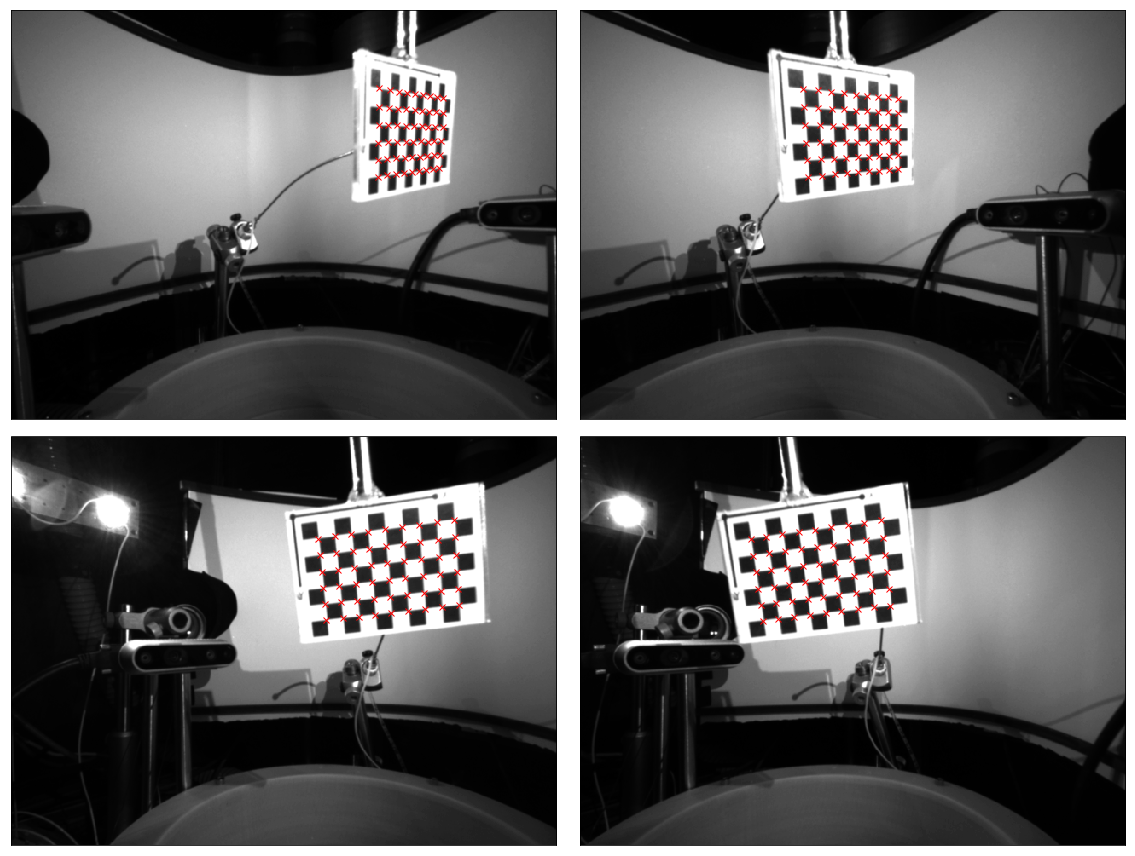

In [135]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

plot_text = False

fig, ax = plt.subplots(2,2,figsize=(16,12))
im = lefts[cams[0]]
ax[0,0].imshow(im, 'gray')
plot_corners(l1, ax[0,0], text=plot_text)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[0]]
ax[0,1].imshow(im, 'gray')
plot_corners(r1, ax[0,1], text=plot_text)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

im = lefts[cams[1]]
ax[1,0].imshow(im, 'gray')
plot_corners(l2, ax[1,0], text=plot_text)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[1]]
ax[1,1].imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax[1,1], text=plot_text)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [137]:
# valid_indices = np.random.choice(valid_indices,size=(100,))
leftpoints = []
rightpoints = []
for ind in valid_indices:
    corners = get_corners_from_file(calibdir, ind)
    # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
    points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    leftpoint = points4d[0:3,:]/points4d[3,:]
    points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
    rightpoint = points4d[0:3,:]/points4d[3,:]
    
    leftpoint = numpy_to_pcd(leftpoint.T)
    rightpoint = numpy_to_pcd(rightpoint.T)
    
    o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
            radius = 0.1, max_nn = 30))
    
    leftpoints.append(leftpoint)
    rightpoints.append(rightpoint)

left = o3.PointCloud()
for i in range(len(leftpoints)):
    left += leftpoints[i]
right = o3.PointCloud()
for i in range(len(rightpoints)):
    right += rightpoints[i]
# leftpoints = np.hstack(leftpoints).T
# rightpoints = np.hstack(rightpoints).T

In [138]:
R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    leftpoints, rightpoints,method='ransac', distance_threshold=0.005)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000739, and correspondence_set size of 25434
Access transformation to get result.
[[ 0.716919 -0.053115  0.695131 -0.092033]
 [ 0.044951  0.99854   0.029939  0.000304]
 [-0.695706  0.009783  0.71826   0.062037]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [  2.386829 -44.037632  -4.237166]


In [139]:
draw_registration_result(left_combined,right_combined, transformation)

# Iterative calibration: fit, calculate reprojection errors, remove outlier checkerboards

In [140]:
def corner_list_to_point_clouds(corner_list, cams, P_l, P_r):
    leftpoints = []
    rightpoints = []
    for corners in corner_list:
        # corners = all_corners[ind]
        # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

        l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
        l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

        points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
        leftpoint = points4d[0:3,:]/points4d[3,:]
        points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
        rightpoint = points4d[0:3,:]/points4d[3,:]

        leftpoint = numpy_to_pcd(leftpoint.T)
        rightpoint = numpy_to_pcd(rightpoint.T)

        o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
                radius = 0.1, max_nn = 30))
        o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
                radius = 0.1, max_nn = 30))

        leftpoints.append(leftpoint)
        rightpoints.append(rightpoint)
    return(leftpoints, rightpoints)

def combine_point_clouds(source_list, target_list):
    source = o3.PointCloud()
    for i in range(len(source_list)):
        source += source_list[i]
    target = o3.PointCloud()
    for i in range(len(target_list)):
        target += target_list[i]
    return(source,target)

In [142]:
cams = ['right_ant', 'right_post']
valid_indices = get_valid_camera_pairs(calibdir, cams)

num_checkerboards = 10
indices = np.random.choice(valid_indices, size=(num_checkerboards,))

# for i in iters:
corner_list = [get_corners_from_file(calibdir, ind) for ind in indices]
source_list, target_list = corner_list_to_point_clouds(corner_list,
                                                      cams,P_l,P_r)
# source, target = combine_point_clouds(source_list, target_list)
R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    source_list, target_list,method='ransac', distance_threshold=0.005)


registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000532, and correspondence_set size of 540
Access transformation to get result.
[[ 0.330077 -0.006161 -0.943934  0.15343 ]
 [ 0.015755  0.999875 -0.001017  0.00998 ]
 [ 0.943823 -0.014536  0.330132  0.07627 ]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [-0.176482 70.723087 -1.069306]


In [143]:
draw_registration_result(left_combined,right_combined, transformation)

# Get points from one camera, triangulate. Transform into other camera, project onto left and right. calculate errors

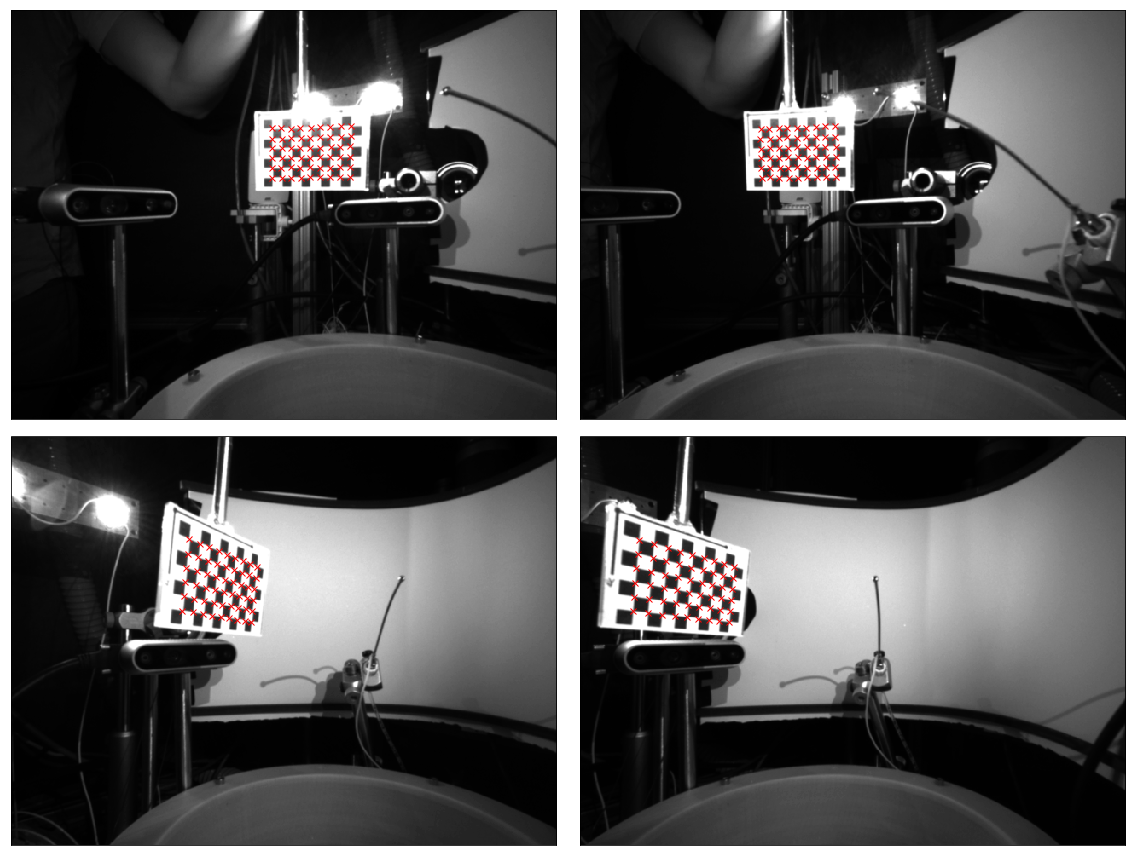

In [145]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = indices[2]
corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

plot_text = False

fig, ax = plt.subplots(2,2,figsize=(16,12))
im = lefts[cams[0]]
ax[0,0].imshow(im, 'gray')
plot_corners(l1, ax[0,0], text=plot_text)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[0]]
ax[0,1].imshow(im, 'gray')
plot_corners(r1, ax[0,1], text=plot_text)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

im = lefts[cams[1]]
ax[1,0].imshow(im, 'gray')
plot_corners(l2, ax[1,0], text=plot_text)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

im = rights[cams[1]]
ax[1,1].imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax[1,1], text=plot_text)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [146]:
left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]

In [147]:
left_in_right = transformation@points4d_0

In [148]:
right = points4d_1[:3,:]

In [149]:
o3.draw_geometries([numpy_to_pcd(left_in_right[:3]), numpy_to_pcd(right)])

Error, transposing...
Error, transposing...


In [154]:
left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]

In [155]:
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)

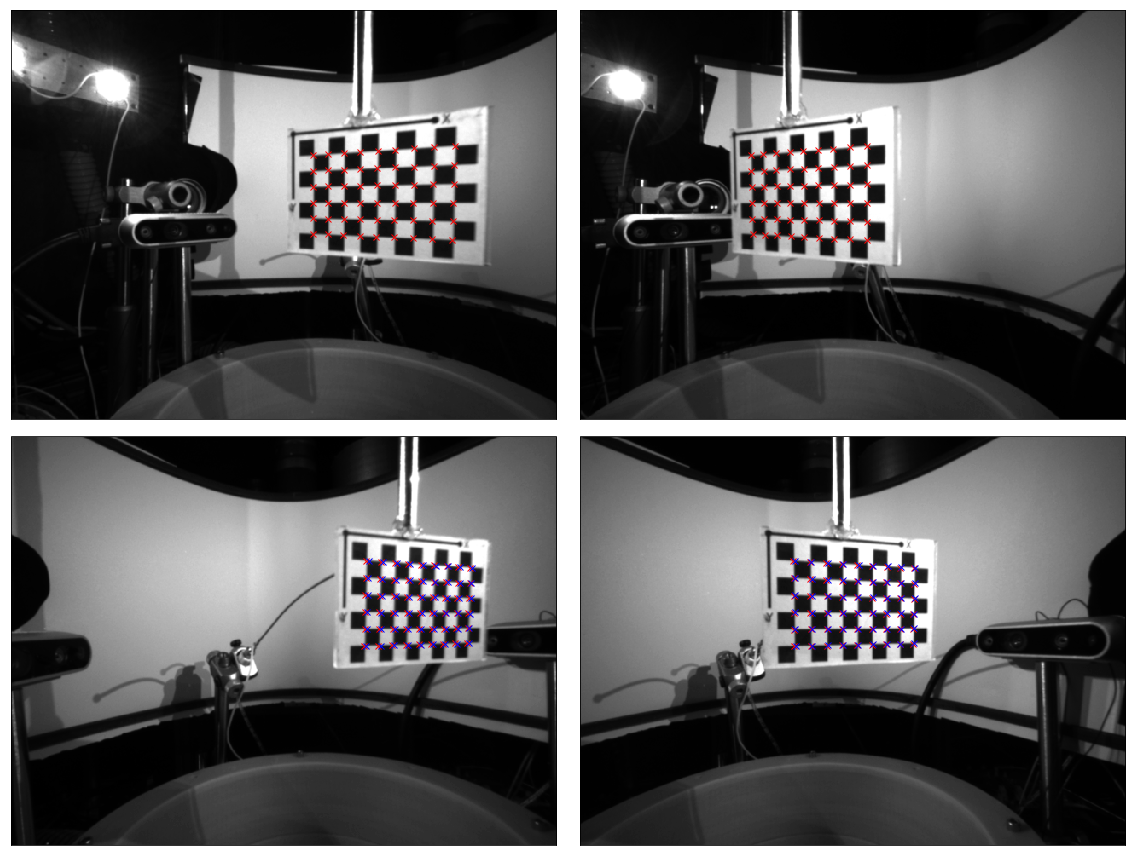

In [169]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = indices[0]
corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
# left_in_right = transformation@points4d_0
# left_in_right = 
# left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
# left_in_right = transformation@points4d_0

l1_reprojected = reproject_points(left_in_right, P_l[cams[1]])
r1_reprojected = reproject_points(left_in_right, P_r[cams[1]])

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
plot_corners(l1, ax, text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
plot_corners(r1, ax, text=plot_text)
# plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
plot_corners(l2, ax, text=plot_text)
plot_corners(l1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax, text=plot_text)
plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [170]:
def calculate_reprojection_errors(corners, cams, P_l, P_r, R, t):
    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

    points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

    source_in_target = R@points4d_0[:3,:] + t[...,np.newaxis]
    source_in_target = np.concatenate((source_in_target, np.ones((1,source_in_target.shape[1]))), axis=0)

    pts_l_projected = reproject_points(source_in_target, P_l[cams[1]])
    pts_r_projected = reproject_points(source_in_target, P_r[cams[1]])

    l_dist = np.sqrt(np.sum((pts_l_projected.squeeze()-l2.squeeze())**2, axis=1))
    r_dist = np.sqrt(np.sum((pts_r_projected.squeeze()-r2.squeeze())**2, axis=1))
    
    return(l_dist.mean(), r_dist.mean())

In [161]:
l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R,t)
print(l_dist, r_dist)

2.6544493121878086 2.7736218765554015


In [162]:
pts_l_projected = l1_reprojected
pts_r_projected = r1_reprojected
pts_l_undistorted = l2.squeeze()
pts_r_undistorted = r2.squeeze()

l_dist = np.sqrt(np.sum((pts_l_projected-pts_l_undistorted)**2, axis=1))
r_dist = np.sqrt(np.sum((pts_r_projected-pts_r_undistorted)**2, axis=1))

In [163]:
num_checkerboards = 10
indices = np.random.choice(valid_indices, size=(num_checkerboards,))

# for i in iters:
corner_list = [get_corners_from_file(calibdir, ind) for ind in indices]
source_list, target_list = corner_list_to_point_clouds(corner_list,
                                                      cams,P_l,P_r)
# source, target = combine_point_clouds(source_list, target_list)
R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    source_list, target_list,method='ransac', distance_threshold=0.005)

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000421, and correspondence_set size of 540
Access transformation to get result.
[[ 0.32783  -0.004004 -0.944728  0.153606]
 [ 0.010885  0.999941 -0.00046   0.010104]
 [ 0.944674 -0.010132  0.327854  0.076634]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [-0.080475 70.861399 -0.699689]


In [164]:
l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R,t)
print(l_dist, r_dist)

2.561895855357533 2.6620597087944797


In [171]:
cams = ['right_post', 'left_post']
threshold = 5
max_num_iters = 10
num_checkerboards = 5

# cams = ['right_ant', 'right_post']
caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
valid_indices = get_valid_camera_pairs(calibdir, cams)
valid_indices = list(valid_indices)
criterion_met = False
iterations = 0
while not criterion_met:

    indices = np.random.choice(valid_indices, size=(num_checkerboards,))

    # for i in iters:
    corner_list = [get_corners_from_file(calibdir, ind) for ind in indices]
    source_list, target_list = corner_list_to_point_clouds(corner_list,
                                                          cams,P_l,P_r)
    # source, target = combine_point_clouds(source_list, target_list)
    R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
        source_list, target_list,method='ransac', distance_threshold=0.005)

    l_dists, r_dists = [], []
    for ind in indices:
        corners = get_corners_from_file(calibdir, ind)
        l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R, t)
        l_dists.append(l_dist)
        r_dists.append(r_dist)
    print('Errors: ', np.mean(l_dists), np.mean(r_dists))
    to_remove = [ind for i,ind in enumerate(indices) if l_dists[i]>threshold or r_dists[i]>threshold]
    for ind in to_remove:
        try:
            valid_indices.remove(ind)
        except ValueError:
            pass
    if len(to_remove)==0 or iterations==max_num_iters:
        criterion_met = True
    iterations+=1

registration::RegistrationResult with fitness = 1.000000, inlier_rmse = 0.000113, and correspondence_set size of 270
Access transformation to get result.
[[ 0.713014  0.034889 -0.700281  0.110432]
 [-0.048097  0.998842  0.000791 -0.004736]
 [ 0.699498  0.033118  0.713867  0.019616]
 [ 0.        0.        0.        1.      ]]
Euler angles:  [ 0.063501 44.449577  2.801311]
Errors:  2.9431457278153927 1.7427784085784908


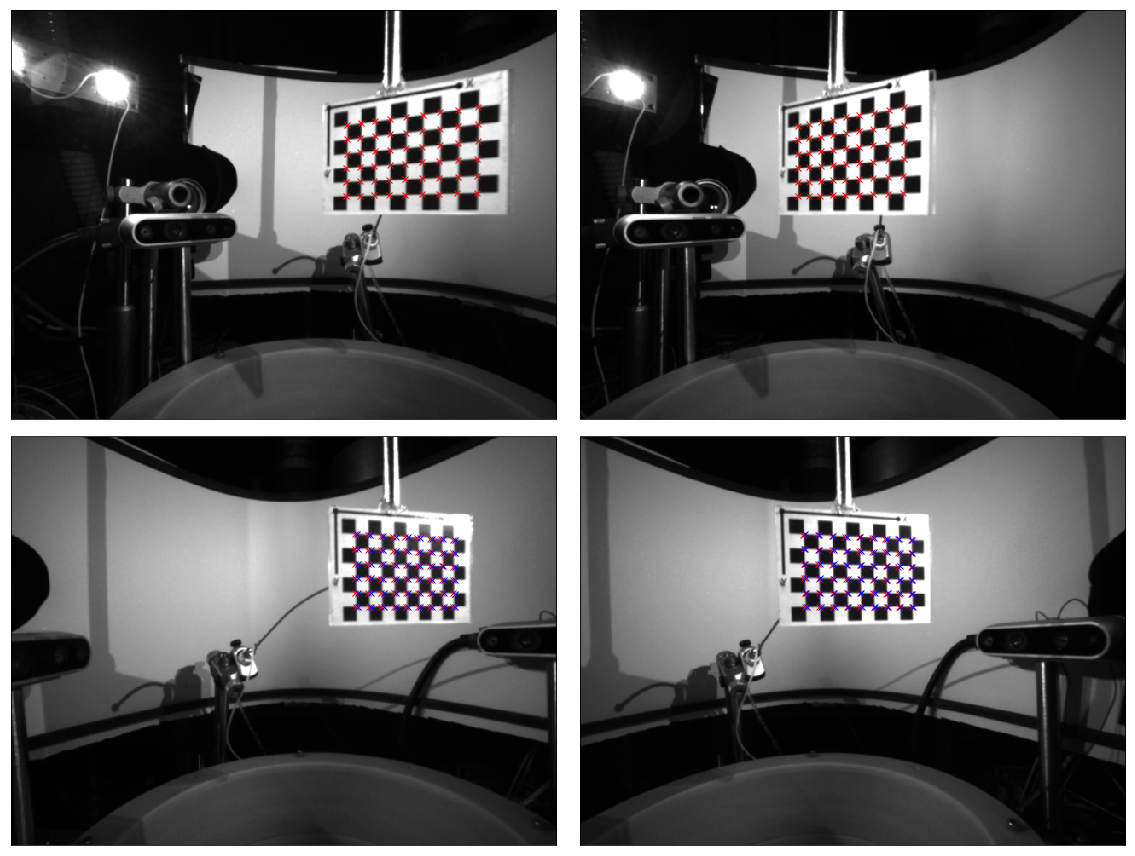

2.6815564020778813 1.5952077416078856


In [174]:
valid_indices = get_valid_camera_pairs(calibdir, cams)
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = valid_indices[3]

corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
# left_in_right = transformation@points4d_0

l1_reprojected = reproject_points(left_in_right, P_l[cams[1]])
r1_reprojected = reproject_points(left_in_right, P_r[cams[1]])

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
plot_corners(l1, ax, text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
plot_corners(r1, ax, text=plot_text)
# plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
plot_corners(l2, ax, text=plot_text)
plot_corners(l1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax, text=plot_text)
plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R, t)
print(l_dist.mean(), r_dist.mean())

# iterative calibration with kabsch

In [185]:
cams = ['left_post', 'left_ant']
threshold = 5
max_num_iters = 5
num_checkerboards = 10

# cams = ['right_ant', 'right_post']
caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
valid_indices = get_valid_camera_pairs(calibdir,  cams)
valid_indices = list(valid_indices)
criterion_met = False
iterations = 0
while not criterion_met:

    indices = np.random.choice(valid_indices, size=(num_checkerboards,))

    # for i in iters:
    corner_list = [get_corners_from_file(calibdir, ind) for ind in indices]
    source_list, target_list = corner_list_to_point_clouds(corner_list,
                                                          cams,P_l,P_r)
    # source, target = combine_point_clouds(source_list, target_list)
    #     R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    #         source_list, target_list,method='icp', distance_threshold=0.005)
    source_points = np.concatenate([np.asarray(i.points) for i in source_list])
    target_points = np.concatenate([np.asarray(i.points) for i in target_list])
    
    R, t, quality = calculate_transformation_kabsch(source_points.T, target_points.T)
    
    l_dists, r_dists = [], []
    for ind in indices:
        corners = get_corners_from_file(calibdir, ind)
        l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R, t)
        l_dists.append(l_dist)
        r_dists.append(r_dist)
    print('Errors: ', np.mean(l_dists), np.mean(r_dists))
    to_remove = [ind for i,ind in enumerate(indices) if l_dists[i]>threshold or r_dists[i]>threshold]
    for ind in to_remove:
        try:
            valid_indices.remove(ind)
        except ValueError:
            pass
    if len(to_remove)==0 or iterations==max_num_iters:
        criterion_met = True
    iterations+=1

Errors:  4.654725584825746 4.2332889921679975
Errors:  4.195176430274378 3.8158647833399613
Errors:  4.788207220200668 4.34563067902595
Errors:  3.9728554078174896 3.558188555539325
Errors:  4.443133948696593 4.001632124430556
Errors:  4.657182663452742 4.198981071425928


In [186]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(source_points)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(target_points)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

In [187]:
left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
right = points4d_1[:3,:]/points4d_1[3,:]

pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(left_in_right[:3,:].T)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

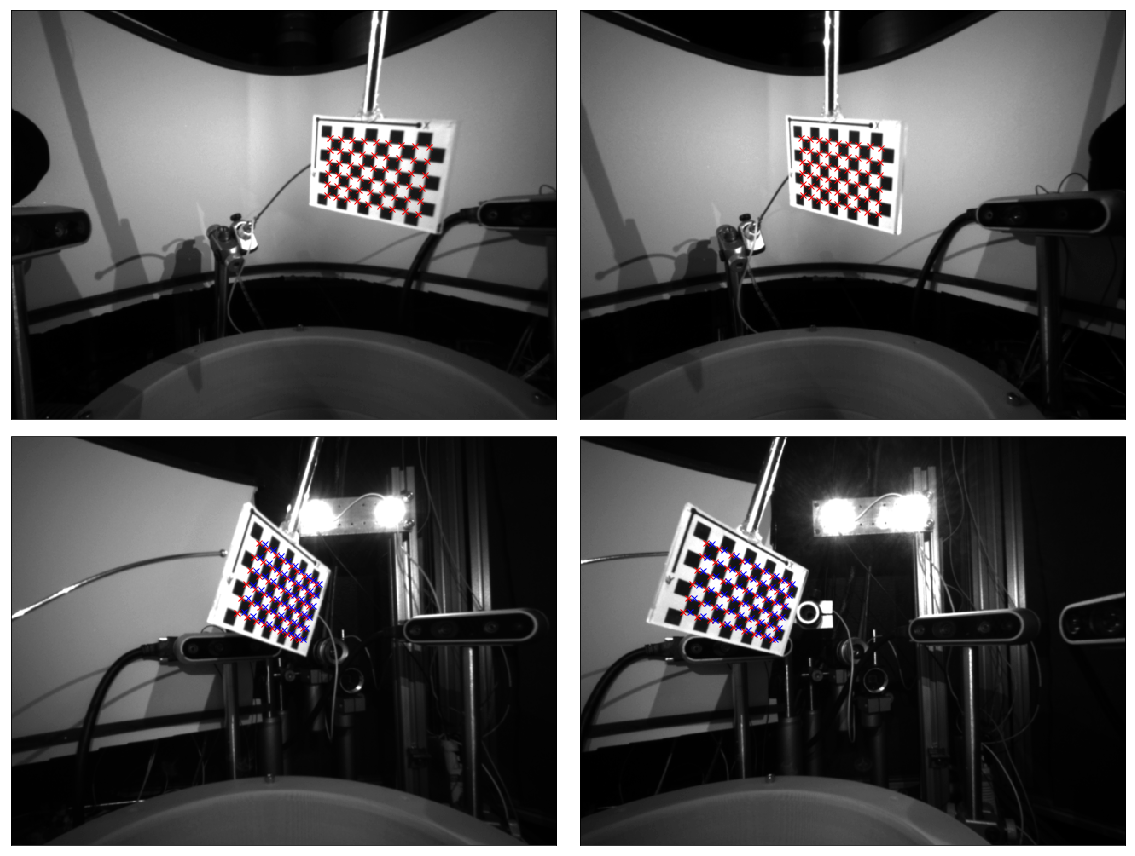

In [189]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = valid_indices[3]

corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
right = points4d_1[:3,:]/points4d_1[3,:]
# left_in_right = transformation@points4d_0

l1_reprojected = reproject_points(left_in_right, P_l[cams[1]])
r1_reprojected = reproject_points(left_in_right, P_r[cams[1]])

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
plot_corners(l1, ax, text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
plot_corners(r1, ax, text=plot_text)
# plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
plot_corners(l2, ax, text=plot_text)
plot_corners(l1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax, text=plot_text)
plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [190]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(left_in_right[:3,:].T)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

# Custom fitting with PyTorch

In [191]:
import torch
from torch.utils import data

In [192]:
def invert_transform(R,t):
    if type(R) == torch.Tensor or type(R) == torch.nn.parameter.Parameter:
        rot = R.t()
        t = - torch.matmul(rot, t)
    elif type(R) == np.ndarray:
        rot = R.T
        t = - np.matmul(rot, t)
    else:
        raise ValueError('invalid input type: ', type(R))
    return(rot, t)

In [193]:
class Rigid(torch.nn.Module):
    def __init__(self, R=None,t=None):
        super().__init__()
        if R is None:
            self.R = torch.nn.Parameter(torch.eye(3), requires_grad=True)
        else:
            self.R = torch.nn.Parameter(torch.from_numpy(R), requires_grad=True)
        if t is None:
            self.t = torch.nn.Parameter(torch.zeros(3,1), requires_grad=True)
        else:
            self.t = torch.nn.Parameter(torch.from_numpy(t), requires_grad=True)
    def forward(self, x, invert=False):
        if not invert:
            out = torch.matmul(self.R, x) + self.t
        else:
            tmp_r, tmp_t = invert_transform(self.R, self.t)
            out = torch.matmul(tmp_r, x) + tmp_t
        return(out)

In [194]:
class RigidLoss(torch.nn.Module):
    def __init__(self, weights=[1,1]):
        super().__init__()
        self.weights = weights
        self.register_buffer('eye', torch.eye(3))
        
    def euclidean_loss(self, x, x_estimated):
        # plot_two_point_clouds(x.numpy(), x_estimated.detach().numpy())
        return(torch.norm(x-x_estimated, dim=0).mean())
    
    def rotation_matrix_loss(self, R):
        Rt = R.t()
        shouldBeIdentity = torch.matmul(Rt, R)
        # I = np.identity(3, dtype = R.dtype)
        n = torch.norm(self.eye - shouldBeIdentity)
        return(n)
    
    def reprojection_loss(self, reprojections):
        (source_l, source_est_l,
            source_r, source_est_r,
            target_l, target_est_l, 
            target_r, target_est_r) = reprojections
        source_l_loss = self.euclidean_loss(source_l, source_est_l)
        source_r_loss = self.euclidean_loss(source_r, source_est_r)
        target_l_loss = self.euclidean_loss(target_l, target_est_l)
        target_r_loss = self.euclidean_loss(target_r, target_est_r)
        return(source_l_loss+source_r_loss+target_l_loss+target_r_loss)
        
    def forward(self, source, source_est, target, target_est, R, reprojections):
        euclidean_loss = self.euclidean_loss(source, source_est) + \
            self.euclidean_loss(target,target_est)
        rotation_matrix_loss = self.rotation_matrix_loss(R)
        reprojection_loss = self.reprojection_loss(reprojections)
        
        loss_components = (euclidean_loss, self.weights[0]*rotation_matrix_loss, 
                          self.weights[1]*reprojection_loss)
        
        # loss = (euclidean_loss + self.weights[0]*rotation_matrix_loss +
        # self.weights[1]*reprojection_loss)
        #         loss = self.euclidean_3d_loss(x, x_estimated)
        return(loss_components)

In [195]:
class Projector(torch.nn.Module):
    def __init__(self, cams, P_l, P_r):
        super().__init__()
        
        src_cam, tgt_cam = cams
        
        self.register_buffer('P_l_src', torch.from_numpy(P_l[src_cam].astype(np.float32)))
        self.register_buffer('P_r_src', torch.from_numpy(P_r[src_cam].astype(np.float32)))
        self.register_buffer('P_l_tgt', torch.from_numpy(P_l[tgt_cam].astype(np.float32)))
        self.register_buffer('P_r_tgt', torch.from_numpy(P_r[tgt_cam].astype(np.float32)))
        
    def append_ones(self, tensor):
        return(torch.cat((tensor, torch.ones(1, tensor.shape[1], device=tensor.device, dtype=tensor.dtype)), dim=0))
    def project(self, x_3d,P):
        # print(x_3d.dtype)
        homogeneous = self.append_ones(x_3d)
        # print(homogeneous.shape)
        # print(P.shape)
        homogeneous = torch.matmul(P, homogeneous)
        # print(homogeneous.shape)
        return(homogeneous[:2,:]/homogeneous[2,:])
    
    def forward(self, source, target, source_est, target_est):
        source_l = self.project(source, self.P_l_src)
        source_est_l = self.project(source_est, self.P_l_src)
        source_r = self.project(source, self.P_r_src)
        source_est_r = self.project(source_est, self.P_r_src)
        
        target_l = self.project(target, self.P_l_tgt)
        target_est_l = self.project(target_est, self.P_l_tgt)
        target_r = self.project(target, self.P_r_tgt)
        target_est_r = self.project(target_est, self.P_r_tgt)
        
        return(source_l, source_est_l,
              source_r, source_est_r,
              target_l, target_est_l, 
              target_r, target_est_r)

In [206]:
class PointData():
    def __init__(self, calibdir,cams, intrinsics, extrinsics, valid_indices):
        # super().__init__()
        
        # valid_indices = get_valid_camera_pairs(calibdir,  cams)
        # print(cams)
        # print(valid_indices)
        self.valid_indices = valid_indices
        self.calibdir = calibdir
        # self.camnames = camnames
        self.cams = cams
        P_l = {}
        P_r = {}
        for cam in cams:
            P_l[cam], P_r[cam] = generate_projection_matrices(intrinsics[cam], extrinsics[cam])
        self.P_l = P_l
        self.P_r = P_r
        
    def __len__(self):
        return(len(self.valid_indices))
    def __getitem__(self, index):
        # print(self.valid_indices[index])
        corners = get_corners_from_file(self.calibdir, self.valid_indices[index])
        assert(len(self.cams)==2)
        
        
        
        ls,rs,clouds = {},{},{}
        for cam in self.cams:
            ls[cam],rs[cam] = corners[cam+'_l'], corners[cam+'_r']
        for cam in self.cams:
            l,r = ls[cam],rs[cam]
            if l is not None and r is not None:
                points4d = triangulate(self.P_l[cam], self.P_r[cam], l, r)
                clouds[cam] =  torch.from_numpy(points4d[:3,:]/points4d[3,:])
            else:
                clouds[cam] = None
        source = clouds[self.cams[0]]
        target = clouds[self.cams[1]]
        return(source,target)

In [196]:
def generate_projection_matrices(intrinsics, extrinsics):
    # assume the left extrinsic is just the identity
    this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l = np.dot(intrinsics, this_P_l)
    P_r = np.dot(intrinsics, extrinsics)
    return(P_l, P_r)

In [198]:
def tensor_to_np(tensor):
    return(tensor.detach().cpu().numpy())

In [199]:
cams = ['right_ant', 'right_post']

caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
    
valid_indices = get_valid_camera_pairs(calibdir, cams)
assert(len(valid_indices)>0)

In [207]:
dataset = PointData(calibdir, cams, intrinsics, extrinsics, valid_indices)

In [208]:
batch_size = 8
num_workers = 0
pin_memory = True
drop_last = False
shuffle = True

device = torch.device('cuda:1')
torch.cuda.set_device(device)

dataloader = data.DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle, num_workers=num_workers,
                            pin_memory=pin_memory,drop_last=drop_last)

In [218]:
weights = [1,1]

dataiter = iter(dataloader)
batch = next(dataiter)
source, target = batch
source = torch.cat([i for i in source],dim=1)
target = torch.cat([i for i in target],dim=1)
R, t, quality = calculate_transformation_kabsch(source.numpy(), target.numpy())
print(rotationMatrixToEulerAngles(R)*180/math.pi)
print(t)

model = Rigid(R,t[:,np.newaxis]).to(device)
criterion = RigidLoss(weights=weights).to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
projector = Projector(cams, P_l, P_r).to(device)

[ -1.882834 -70.560881   2.054811]
[0.152895 0.010193 0.075842]


In [81]:
# source, target = source.to(device), target.to(device)
# target_est = model(source)
# source_est = model(target, invert=True)
# reprojections = projector(source, target, source_est, target_est)
# loss = criterion(source, source_est, target, target_est, model.R, reprojections)

In [210]:
num_epochs = 1
progressbar = tqdm(range(num_epochs))
step = 0
for i in progressbar:
    dataiter = iter(dataloader)
    for batch in dataiter:
        source, target = batch
        source = torch.cat([i for i in source],dim=1)
        target = torch.cat([i for i in target],dim=1)
        source, target = source.to(device), target.to(device)
        target_est = model(source)
        source_est = model(target, invert=True)
        reprojections = projector(source, target, source_est, target_est)
        loss_components = criterion(source, source_est, target, target_est, model.R, reprojections)
        loss = torch.sum(torch.stack(loss_components))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step==0:
            print('Kabsch only: %.6f' %loss.item())
            print('kabsch reprojection: %.6f' %criterion.reprojection_loss(reprojections).item())
        R = model.R.detach().cpu().numpy()
        t = model.t.detach().cpu().numpy()
        print([tensor_to_np(i) for i in loss_components])
        # print(rotationMatrixToEulerAngles(R)*180/math.pi)
        # print(t)
        step+=1
    # print(loss.item())
    # print(loss.item())
    progressbar.set_description('Loss: %.4f' %(loss.item()*1000))
    R = model.R.detach().cpu().numpy()
    t = model.t.detach().cpu().numpy()
    print([tensor_to_np(i) for i in loss_components])
    # print(rotationMatrixToEulerAngles(R)*180/math.pi)
    # print(t)
    print(criterion.reprojection_loss(reprojections).item())

Kabsch only: 3.866101
kabsch reprojection: 3.865065
[array(0.001036, dtype=float32), array(0., dtype=float32), array(3.865065, dtype=float32)]
[array(0.489923, dtype=float32), array(0.041881, dtype=float32), array(1114.41, dtype=float32)]
[array(0.074876, dtype=float32), array(0.211887, dtype=float32), array(232.33034, dtype=float32)]
[array(1.226782, dtype=float32), array(0.212303, dtype=float32), array(3499.5073, dtype=float32)]
[array(4.71633, dtype=float32), array(0.486803, dtype=float32), array(4956.335, dtype=float32)]
[array(13.723828, dtype=float32), array(14.08483, dtype=float32), array(842.82275, dtype=float32)]
[array(13.841403, dtype=float32), array(14.048346, dtype=float32), array(805.9858, dtype=float32)]
[array(13.903913, dtype=float32), array(14.014452, dtype=float32), array(889.86914, dtype=float32)]
[array(13.93757, dtype=float32), array(13.988417, dtype=float32), array(721.28156, dtype=float32)]
[array(14.005816, dtype=float32), array(13.959991, dtype=float32), array

In [ ]:
# # valid_indices = np.random.choice(valid_indices,size=(100,))
# leftpoints = []
# rightpoints = []
# for i in range(batch_size):
#     ind = valid_indices[i]
#     print(ind)
#     # corners = all_corners[ind]
#     corners = get_corners_from_file(calibdir, ind)
#     # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

#     l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
#     l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
#     points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
#     leftpoint = points4d[0:3,:]/points4d[3,:]
#     points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
#     rightpoint = points4d[0:3,:]/points4d[3,:]
    
#     #     leftpoint = numpy_to_pcd(leftpoint.T)
#     #     rightpoint = numpy_to_pcd(rightpoint.T)

#     #     o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
#     #             radius = 0.1, max_nn = 30))
#     #     o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
#     #             radius = 0.1, max_nn = 30))
    
#     leftpoints.append(leftpoint)
#     rightpoints.append(rightpoint)

# # left = o3.PointCloud()
# # for i in range(len(leftpoints)):
# #     left += leftpoints[i]
# # right = o3.PointCloud()
# # for i in range(len(rightpoints)):
# #     right += rightpoints[i]
# # leftpoints = np.hstack(leftpoints).T
# # rightpoints = np.hstack(rightpoints).T
# leftpoints = np.hstack(leftpoints)
# rightpoints = np.hstack(rightpoints)

In [211]:
source, target = source.to(device), target.to(device)
target_est = model(source)
source_est = model(target, invert=True)
reprojections = projector(source, target, source_est, target_est)
loss = criterion(source, source_est, target, target_est, model.R, reprojections)

In [212]:
# source_np = source.numpy().reshape(3,-1)
# target_np = target.numpy().reshape(3,-1)
# target_est_np = target_est.detach().numpy().reshape(3,-1)
source_np = source.detach().cpu().numpy()
target_np = target.detach().cpu().numpy()
target_est_np = target_est.detach().cpu().numpy()

In [213]:
def plot_two_point_clouds(cloud1, cloud2):
    cloud1 = numpy_to_pcd(cloud1.squeeze())
    cloud2 = numpy_to_pcd(cloud2.squeeze())
    cloud1.paint_uniform_color([1,0,0])
    cloud2.paint_uniform_color([0,0,1])
    o3.draw_geometries([cloud1,cloud2])

In [214]:
plot_two_point_clouds(target_np, target_est_np)

Error, transposing...
Error, transposing...


In [226]:
valid_indices = get_valid_camera_pairs(calibdir, cams)
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = valid_indices[3]

corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

points3d = points4d_0[:3,:]/points4d_0[3,:]

tmp_t = t if t.ndim==2 else t[:,np.newaxis]
left_in_right = R@points3d + tmp_t
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
# left_in_right = transformation@points4d_0

l1_reprojected = reproject_points(left_in_right, P_l[cams[1]])
r1_reprojected = reproject_points(left_in_right, P_r[cams[1]])

# R_inv, t_inv = invert_transform(R, t)
# right_in_left = R_inv @ points4d_1
# l2_reprojected = reproject_points()

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
plot_corners(l1, ax, text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
plot_corners(r1, ax, text=plot_text)
# plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
plot_corners(l2, ax, text=plot_text)
plot_corners(l1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax, text=plot_text)
plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

# l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R, t)
# print(l_dist.mean(), r_dist.mean())

# testing projector

In [227]:
projector = Projector(cams, P_l, P_r).to(device)

In [228]:
valid_indices = get_valid_camera_pairs(calibdir, cams)
ind = np.random.randint(low=0,high=len(valid_indices))
source, target = dataset[ind]
source, target = source.to(device), target.to(device)
target_est = model(source)
source_est = model(target, invert=True)
image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)
results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

In [223]:
%matplotlib qt5

In [229]:
valid_indices = get_valid_camera_pairs(calibdir,  cams)
ind = np.random.randint(low=0,high=len(valid_indices))
source, target = dataset[ind]
source, target = source.to(device), target.to(device)
target_est = model(source)
source_est = model(target, invert=True)
image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)
results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results


plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
corners = tensor_to_np(source_l).T
plot_corners(corners, ax, text=plot_text)
corners = tensor_to_np(source_est_l).T
plot_corners(corners, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
corners = tensor_to_np(source_r).T
plot_corners(corners, ax, text=plot_text)
corners = tensor_to_np(source_est_r).T
plot_corners(corners, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
corners = tensor_to_np(target_l).T
plot_corners(corners, ax, text=plot_text)
corners = tensor_to_np(target_est_l).T
plot_corners(corners, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
corners = tensor_to_np(target_r).T
plot_corners(corners, ax, text=plot_text)
corners = tensor_to_np(target_est_r).T
plot_corners(corners, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

# Put Kabsch, forwards and backwards rotations, reprojection, and reprojection errors into nice Numpy classes for publishing

In [230]:
def invert_transform(R,t):
    if type(R) == torch.Tensor or type(R) == torch.nn.parameter.Parameter:
        rot = R.t()
        t = - torch.matmul(rot, t)
    elif type(R) == np.ndarray:
        rot = R.T
        t = - np.matmul(rot, t)
    else:
        raise ValueError('invalid input type: ', type(R))
    return(rot, t)

In [231]:
# from Intel Realsense Github examples
def kabsch_rmsd(P, Q):
    """
    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        root-mean squared deviation
    """
    P = kabsch_rotate(P, Q)
    return rmsd(P, Q)


def kabsch_rotate(P, Q):
    """
    Rotate matrix P unto matrix Q using Kabsch algorithm.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    P : array
        (N,D) matrix, where N is points and D is dimension,
        rotated
    """
    U = kabsch(P, Q)

    # Rotate P
    P = np.dot(P, U)
    return P


def kabsch(P, Q):
    """
    The optimal rotation matrix U is calculated and then used to rotate matrix
    P unto matrix Q so the minimum root-mean-square deviation (RMSD) can be
    calculated.
    Using the Kabsch algorithm with two sets of paired point P and Q, centered
    around the centroid. Each vector set is represented as an NxD
    matrix, where D is the the dimension of the space.
    The algorithm works in three steps:
    - a translation of P and Q
    - the computation of a covariance matrix C
    - computation of the optimal rotation matrix U
    http://en.wikipedia.org/wiki/Kabsch_algorithm
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    U : matrix
        Rotation matrix (D,D)
    Example
    -----
    TODO
    """

    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U



def centroid(X):
    """
    Calculate the centroid from a vectorset X.
    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.
    C = sum(X)/len(X)
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    C : float
        centeroid
    """
    C = X.mean(axis=0)
    return C


def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation
    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)

def calculate_transformation_kabsch(src_points, dst_points):
    """
    Calculates the optimal rigid transformation from src_points to
    dst_points
    (regarding the least squares error)
    Parameters:
    -----------
    src_points: array
        (3,N) matrix
    dst_points: array
        (3,N) matrix

    Returns:
    -----------
    rotation_matrix: array
        (3,3) matrix

    translation_vector: array
        (3,1) matrix
    rmsd_value: float
    """
    assert src_points.shape == dst_points.shape
    if src_points.shape[0] != 3:
        raise Exception("The input data matrix had to be transposed in order to compute transformation.")

    src_points = src_points.transpose()
    dst_points = dst_points.transpose()

    src_points_centered = src_points - centroid(src_points)
    dst_points_centered = dst_points - centroid(dst_points)

    rotation_matrix = kabsch(src_points_centered, dst_points_centered)
    rmsd_value = kabsch_rmsd(src_points_centered, dst_points_centered)

    translation_vector = centroid(dst_points) - np.matmul(centroid(src_points), rotation_matrix)

    return rotation_matrix.transpose(), translation_vector.transpose(), rmsd_value

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    # assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [233]:
valid_indices = get_valid_camera_pairs(calibdir, cams)

In [236]:
source.device

device(type='cpu')

In [237]:
source, target = dataset[ind]
source, target = source.to(device), target.to(device)
target_est = model(source)
source_est = model(target, invert=True)
image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)
results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

# RealsensePair class
* Two cameras: source and target. Each has:
    * Intrinsic
    * Extrinsic
    * 2 projection matrices
* Methods
    * Fit: with two point clouds, use Kabsch to get rotations
    * Calculate reprojection errors: for each simultaneous point cloud, get the mean reprojection error for all 4 images
    * Fit_iterative: just like Calibrator class
    
# Transformer class
* N cameras
* Use Transformer classes to fit pairwise transforms between two adjacent cameras
* Use combinations of pairwise rotations to come up with any arbitrary transform
* Methods
    * transform: (pointcloud, source_cam, dest_cam)
        * Rotate point cloud from source_1 coordinates to dest_cam coordinates

In [238]:
intrinsics['left_post'] = np.array([[385.8394165, 0, 317.54],[0,385.839,243.379],[0,0,1]])
intrinsics['right_post'] = np.array([[385.2056, 0, 320.9507],[0,385.2056,244.7523],[0,0,1]])
intrinsics['left_ant']  = np.array([[393.30001, 0, 315.6109],[0,393.30001,240.3131],[0,0,1]])
intrinsics['right_ant'] = np.array([[383.727, 0, 318.0106],[0,383.727,241.5627],[0,0,1]])

extrinsics = {}
extrinsics['left_post'] = np.hstack((np.eye(3,3), np.array([-0.04990066,0,0])[...,np.newaxis]))
extrinsics['right_post'] = np.hstack((np.eye(3,3), np.array([-0.04994235,0,0])[...,np.newaxis]))
extrinsics['left_ant'] = np.hstack((np.eye(3,3), np.array([-0.04998056,0,0])[...,np.newaxis]))
extrinsics['right_ant'] = np.hstack((np.eye(3,3), np.array([-0.04983759,0,0])[...,np.newaxis]))

In [239]:
P_l = {}
P_r = {}
for camname in list(extrinsics.keys()):
    this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l[camname] = np.dot(intrinsics[camname], this_P_l)
    P_r[camname] = np.dot(intrinsics[camname], extrinsics[camname])
print(extrinsics)

{'left_post': array([[ 1.      ,  0.      ,  0.      , -0.049901],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'right_post': array([[ 1.      ,  0.      ,  0.      , -0.049942],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'left_ant': array([[ 1.      ,  0.      ,  0.      , -0.049981],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'right_ant': array([[ 1.      ,  0.      ,  0.      , -0.049838],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]])}


In [240]:
class PointData():
    def __init__(self, calibdir,cams, intrinsics, extrinsics, valid_indices):
        # super().__init__()
        
        # valid_indices = get_valid_camera_pairs(calibdir,  cams)
        # print(cams)
        # print(valid_indices)
        self.valid_indices = valid_indices
        self.calibdir = calibdir
        # self.camnames = camnames
        self.cams = cams
        P_l = {}
        P_r = {}
        for cam in cams:
            P_l[cam], P_r[cam] = generate_projection_matrices(intrinsics[cam], extrinsics[cam])
        self.P_l = P_l
        self.P_r = P_r
        
    def __len__(self):
        return(len(self.valid_indices))
    def __getitem__(self, index):
        # print(self.valid_indices[index])
        corners = get_corners_from_file(self.calibdir, self.valid_indices[index])
        
        ls,rs,clouds = {},{},{}
        for cam in self.cams:
            ls[cam],rs[cam] = corners[cam+'_l'], corners[cam+'_r']
        for cam in self.cams:
            l,r = ls[cam],rs[cam]
            if l is not None and r is not None:
                points4d = triangulate(self.P_l[cam], self.P_r[cam], l, r)
                clouds[cam] =  points4d[:3,:]/points4d[3,:]
            else:
                clouds[cam] = None
        return(clouds)
        
        #         l1, r1 = corners[self.cams[0]+'_l'], corners[self.cams[0]+'_r']
        #         l2, r2 = corners[self.cams[1]+'_l'], corners[self.cams[1]+'_r']
        #         source = None
        #         target = None
        #         if l1 is not None and r1 is not None:
        #             points4d_0 = triangulate(self.P_l[self.cams[0]], self.P_r[self.cams[0]], l1, r1)
        #             source = points4d_0[:3,:]/points4d_0[3,:]
        #         if l2 is not None and r2 is not None:
        #             points4d_1 = triangulate(self.P_l[self.cams[1]], self.P_r[self.cams[1]], l2, r2)
        #             target = points4d_1[:3,:]/points4d_1[3,:]
        #         return(source, target)

In [241]:
class RealsensePair():
    def __init__(self, cams,source_intrinsic, source_extrinsic, target_intrinsic, target_extrinsic):
        
        this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
        self.P_l_source = np.dot(source_intrinsic, this_P_l)
        self.P_r_source = np.dot(source_intrinsic, source_extrinsic)
        self.P_l_target = np.dot(target_intrinsic, this_P_l)
        self.P_r_target = np.dot(target_intrinsic, target_extrinsic)
        self.cams = cams
        
        self.intrinsics = {}
        self.extrinsics = {}
        self.intrinsics[cams[0]] = source_intrinsic
        self.intrinsics[cams[1]] = target_intrinsic
        self.extrinsics[cams[0]] = source_extrinsic
        self.extrinsics[cams[1]] = target_extrinsic
        
    def append_ones(self, array):
        return(np.concatenate((array, np.ones((1, array.shape[1]), dtype=array.dtype)), axis=0))
    
    def project(self, x_3d,P):
        assert(x_3d.ndim==2)
        # print(x_3d.dtype)
        homogeneous = self.append_ones(x_3d)
        # print(homogeneous.shape)
        # print(P.shape)
        homogeneous = P @ homogeneous # torch.matmul(P, homogeneous)
        # print(homogeneous.shape)
        return(homogeneous[:2,:]/homogeneous[2,:])
    
    def fit(self, source_cloud, target_cloud):
        
        R, t, quality = calculate_transformation_kabsch(source_cloud, target_cloud)
        R_inv, t_inv = invert_transform(R,t)
        self.R = R
        self.t = t[:,np.newaxis]
        self.R_inv = R_inv
        self.t_inv = t_inv[:,np.newaxis]
        
        print('R:', R)
        print('t:', t)
        print('Euler angles: ', rotationMatrixToEulerAngles(R)*180/math.pi)
        print('RMSD: %.6f' %quality)
    
    def rotate(self, cloud, target_to_source=False):
        
        if target_to_source:
            return(self.R_inv @ cloud + self.t_inv)
        else:
            return(self.R @ cloud + self.t)
    
    def reproject(self, source, target, source_est, target_est):
        source_l = self.project(source, self.P_l_source)
        source_est_l = self.project(source_est, self.P_l_source)
        source_r = self.project(source, self.P_r_source)
        source_est_r = self.project(source_est, self.P_r_source)
        
        target_l = self.project(target, self.P_l_target)
        target_est_l = self.project(target_est, self.P_l_target)
        target_r = self.project(target, self.P_r_target)
        target_est_r = self.project(target_est, self.P_r_target)
        
        return(source_l, source_est_l,
              source_r, source_est_r,
              target_l, target_est_l, 
              target_r, target_est_r)
    
    def euclidean_distance(self, cloud1, cloud2):
        return(np.linalg.norm(cloud1 - cloud2,axis=0))
    
    def calculate_reprojection_errors(self, reprojections):
        (source_l, source_est_l,
            source_r, source_est_r,
            target_l, target_est_l, 
            target_r, target_est_r) = reprojections
        # sum across dimensions, mean across points
        error_l1 = self.euclidean_distance(source_l, source_est_l).mean()
        error_r1 = self.euclidean_distance(source_r, source_est_r).mean()
        error_l2 = self.euclidean_distance(target_l, target_est_l).mean()
        error_r2 = self.euclidean_distance(target_r, target_est_r).mean()
        
        # mean across all 4 images
        error = np.array([error_l1, error_r1, error_l2, error_r2]).mean()
        
        return(error)
    
    def is_outlier(self, errors, auto_outlier=5,z_threshold=3, abs_threshold=0.5):
        zscored = (errors-errors.mean())/np.std(errors)
        is_def_wrong = errors > auto_outlier
        
        is_outlier = np.logical_and(zscored>z_threshold, errors>abs_threshold)
        outliers = np.logical_or(is_def_wrong, is_outlier)
        return(outliers)
    
    def visualize_outliers(self, errors, outliers, fig=None):
        zscored = (errors-errors.mean())/np.std(errors)

        x = np.arange(0, len(errors))

        if fig is None:
            fig = plt.figure(figsize=(8,4))
        else:
            fig.clf()

        # fig, axes = plt.subplots(1,2)
        ax = fig.add_subplot(121)
        ax.plot(x, errors)
        ax.scatter(x[outliers], errors[outliers],c=errors[outliers])
        ax.set_title('Mean error per checkerboard, pixels')
        ax = fig.add_subplot(122)
        ax.plot(x, zscored)
        ax.scatter(x[outliers], zscored[outliers],c=zscored[outliers])
        ax.set_title('Z-scored')
        plt.draw()
        plt.show()
        
    def calibrate_iterative(self, calibdir):
        plt.style.use('ggplot')
        max_iters = 20
        valid_indices = get_valid_camera_pairs(calibdir, self.cams)

        should_continue = True
        loop = 0
        while should_continue:
            dataset = PointData(calibdir, self.cams, self.intrinsics,self.extrinsics, valid_indices)
            source, target = [], []
            for i in range(len(dataset)):
                clouds = dataset[i]
                src,tgt = clouds[self.cams[0]], clouds[self.cams[1]]
                source.append(src)
                target.append(tgt)

            source = np.concatenate(source,axis=1)
            target = np.concatenate(target,axis=1)

            self.fit(source,target)

            errors = []
            for i in range(len(dataset)):
                clouds = dataset[i]
                source,target = clouds[self.cams[0]], clouds[self.cams[1]]
                target_est = self.rotate(source)
                source_est = self.rotate(target, target_to_source=True)
                reprojections = self.reproject(source,target,source_est,target_est)
                error = self.calculate_reprojection_errors(reprojections)
                errors.append(error)
            errors = np.array(errors)
            outliers = self.is_outlier(errors)
            self.visualize_outliers(errors,outliers)
            plt.pause(1)
            if outliers.sum()>0:
                valid_indices = valid_indices[np.logical_not(outliers)]
            else:
                should_continue = False
            if loop >=max_iters:
                should_continue=False
            loop+=1
            

In [242]:
cams = ['left_post', 'left_ant']
pair = RealsensePair(cams, intrinsics[cams[0]], extrinsics[cams[0]],
                     intrinsics[cams[1]], extrinsics[cams[1]])

In [244]:
%matplotlib inline

R: [[-0.002489  0.054955 -0.998486]
 [ 0.041163  0.997648  0.054807]
 [ 0.999149 -0.040964 -0.004745]]
t: [ 0.160355 -0.01055   0.112451]
Euler angles:  [-96.607829 -87.636566  93.46043 ]
RMSD: 0.000626


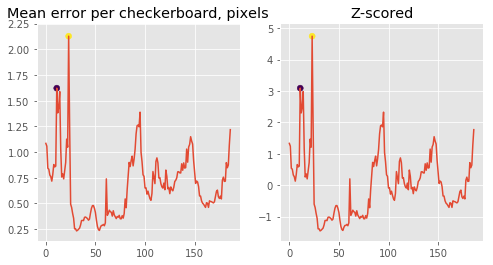

R: [[-0.002591  0.054852 -0.998491]
 [ 0.040935  0.997663  0.0547  ]
 [ 0.999158 -0.040731 -0.00483 ]]
t: [ 0.160357 -0.010522  0.112463]
Euler angles:  [-96.762868 -87.649263  93.621582]
RMSD: 0.000578


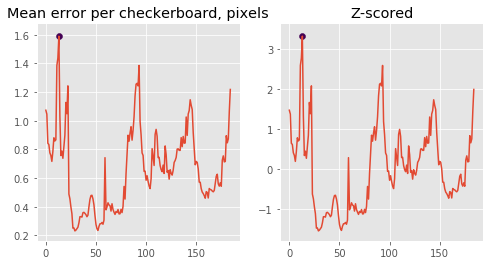

R: [[-0.00257   0.054804 -0.998494]
 [ 0.040963  0.997665  0.054653]
 [ 0.999157 -0.040761 -0.004809]]
t: [ 0.160356 -0.010517  0.112459]
Euler angles:  [-96.728331 -87.647696  93.589751]
RMSD: 0.000543


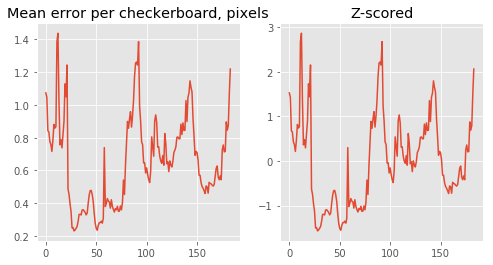

In [245]:
pair.calibrate_iterative(calibdir)

In [247]:
from collections import defaultdict 
# from here
# https://www.geeksforgeeks.org/generate-graph-using-dictionary-python/
# https://www.python.org/doc/essays/graphs/
# https://stackoverflow.com/questions/19472530/representing-graphs-data-structure-in-python

class Graph():
    """ Graph data structure, undirected by default. """

    def __init__(self, connections, directed=False):
        self._graph = defaultdict(set)
        self._directed = directed
        self.add_connections(connections)

    def add_connections(self, connections):
        """ Add connections (list of tuple pairs) to graph """

        for node1, node2 in connections:
            self.add(node1, node2)

    def add(self, node1, node2):
        """ Add connection between node1 and node2 """

        self._graph[node1].add(node2)
        if not self._directed:
            self._graph[node2].add(node1)

    def remove(self, node):
        """ Remove all references to node """

        for n, cxns in self._graph.iteritems():
            try:
                cxns.remove(node)
            except KeyError:
                pass
        try:
            del self._graph[node]
        except KeyError:
            pass

    def is_connected(self, node1, node2):
        """ Is node1 directly connected to node2 """

        return node1 in self._graph and node2 in self._graph[node1]

    def find_all_paths(self, node1, node2, path=[]):
        """ Find any path between node1 and node2 (may not be shortest) """

        path = path + [node1]
        if node1 == node2:
            return path
        if node1 not in self._graph:
            return None
        paths = [] 
        for node in self._graph[node1]:
            if node not in path:
                new_paths = self.find_all_paths(node, node2, path)
                for newpath in new_paths:
                    paths.append(newpath) 
        return paths
    
    def find_shortest_path(self, node1, node2, path=[]):
        path = path + [node1] 
        if node1 == node2: 
            return path 
        shortest = None
        for node in self._graph[node1]: 
            if node not in path: 
                newpath = self.find_shortest_path(node, node2, path) 
                if newpath: 
                    if not shortest or len(newpath) < len(shortest): 
                        shortest = newpath 
        return shortest 

    
    def __str__(self):
        return '{}({})'.format(self.__class__.__name__, dict(self._graph))

In [249]:
pairs = [('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]


In [250]:
g = Graph(pairs, directed=True)

In [251]:
path = g.find_shortest_path('right_ant', 'left_ant')

In [253]:
pair = pairs[0]
rs = RealsensePair(pair, 
                   intrinsics[pair[0]], 
                      extrinsics[pair[0]], 
                      intrinsics[pair[1]], 
                      extrinsics[pair[1]])

R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


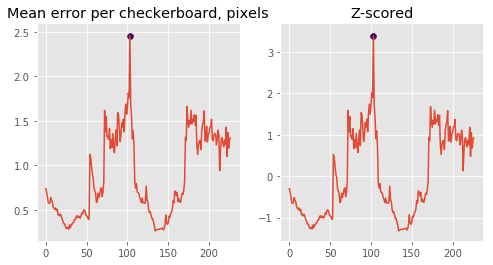

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


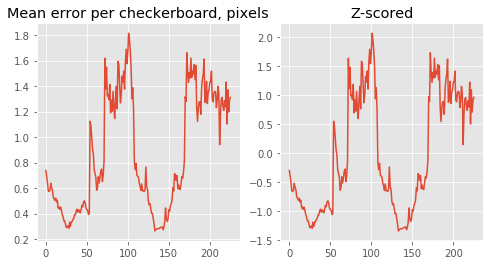

In [254]:
rs.calibrate_iterative(calibdir)

In [255]:
class Transformer():
    def __init__(self, calibdir, intrinsics, extrinsics, pairs, reference='left_ant'):
        self.rs = {}
        self.R = {}
        self.t = {}
        pairs = pairs.copy()
        for pair in pairs:
            rs = RealsensePair(pair, 
                               intrinsics[pair[0]], 
                               extrinsics[pair[0]], 
                               intrinsics[pair[1]], 
                               extrinsics[pair[1]])
            print('~~~ Calibrating pair: ', pair, '~~~')
            rs.calibrate_iterative(calibdir)
            self.R[pair] = rs.R
            self.t[pair] = rs.t
            self.R[(pair[1],pair[0])] = rs.R_inv
            self.t[(pair[1],pair[0])] = rs.t_inv
            
            self.rs[pair] = rs
            
        for i in range(len(pairs)):
            pair = pairs[i]
            pairs.append((pair[1], pair[0]))
            
        self.pairs = pairs
        self.cams = list(intrinsics.keys())
        self.graph = Graph(self.pairs, directed=True)
        self.calibdir = calibdir
    def compose_transforms(self, R1, R2, t1, t2):
        R3 = R2 @ R1
        t3 = R2@t1 + t2
        return(R3,t3)
    
    def compose(self, sequence):
        src, dest = sequence[0][0], sequence[1][1]
        R3, t3 = compose_transforms(self.R[sequence[0]], 
                                    self.R[sequence[1]],
                                    self.t[sequence[0]],
                                    self.t[sequence[1]])
        if len(sequence)==2:
            return(R3,t3)
        else:
            pair = (src,dest)
            sequence2 = sequence.copy()
            del(sequence2[0:2])
            sequence2.insert(0, pair)
            self.R[pair] = R3
            self.t[pair] = t3
            return(self.compose(sequence2))
    def nodes_to_sequence(self, node1,node2):
        path = self.graph.find_shortest_path(node1,node2)
        sequence = []
        for i in range(len(path)-1):
            sequence.append((path[i], path[i+1]))
        return(sequence)
    
    def transform(self, cloud, node1,node2=None):
        if node2 is None:
            node2 = self.reference
            
        if cloud.shape[1] == 3:
            cloud = cloud.T
        if node1 == node2:
            return(cloud)
        pair = (node1, node2)
        
        if pair in list(self.R.keys()):
            R = self.R[pair]
            t = self.t[pair]
        else:
            sequence = self.nodes_to_sequence(node1, node2)
            R, t = self.compose(sequence)
        transformed = R @ cloud + t
        return(transformed)

In [256]:
pairs

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [257]:
pairs = [('right_ant', 'right_post'),
         ('right_post', 'left_post'),
         ('left_post', 'left_ant')]

In [258]:
%matplotlib inline

~~~ Calibrating pair:  ('right_ant', 'right_post') ~~~
R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


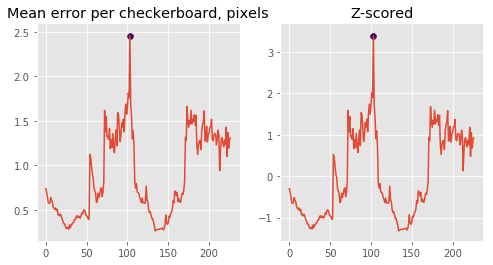

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


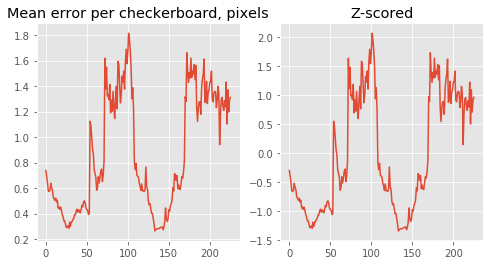

~~~ Calibrating pair:  ('right_post', 'left_post') ~~~
R: [[ 0.713329  0.034569 -0.699976]
 [-0.048291  0.998833  0.000117]
 [ 0.699164  0.033719  0.714166]]
t: [ 0.110353 -0.00463   0.019609]
Euler angles:  [  2.703221 -44.359943  -3.872908]
RMSD: 0.000423


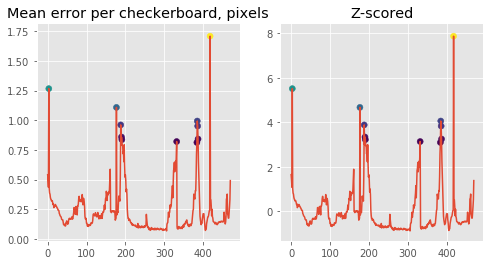

R: [[ 0.713241  0.034609 -0.700064]
 [-0.048346  0.998831  0.000123]
 [ 0.699249  0.033757  0.714081]]
t: [ 0.110373 -0.004627  0.019613]
Euler angles:  [  2.706569 -44.366802  -3.877773]
RMSD: 0.000325


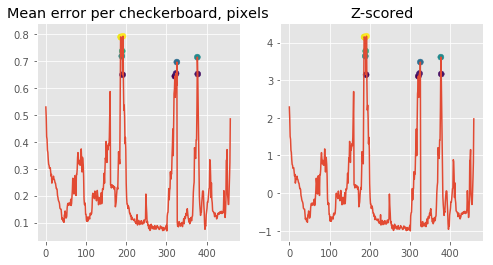

R: [[ 0.713171  0.034681 -0.700131]
 [-0.048422  0.998827  0.000153]
 [ 0.699315  0.033793  0.714014]]
t: [ 0.11039  -0.004624  0.019615]
Euler angles:  [  2.709646 -44.3721    -3.884234]
RMSD: 0.000260


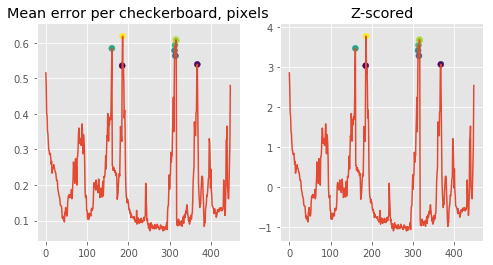

R: [[ 0.713151  0.034682 -0.700152]
 [-0.048432  0.998826  0.000146]
 [ 0.699335  0.033806  0.713994]]
t: [ 0.110395 -0.004622  0.019616]
Euler angles:  [  2.710778 -44.373687  -3.88516 ]
RMSD: 0.000237


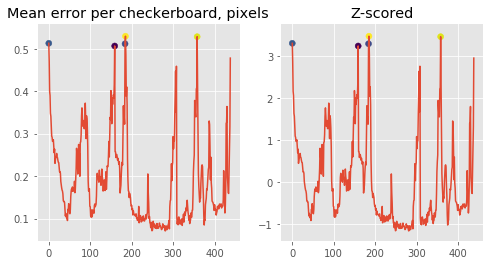

R: [[ 0.713173  0.034658 -0.700131]
 [-0.048416  0.998827  0.000127]
 [ 0.699314  0.033807  0.714014]]
t: [ 0.110391 -0.004621  0.019614]
Euler angles:  [  2.710816 -44.372028  -3.883733]
RMSD: 0.000227


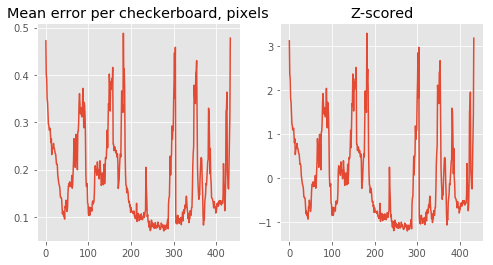

~~~ Calibrating pair:  ('left_post', 'left_ant') ~~~
R: [[-0.002489  0.054955 -0.998486]
 [ 0.041163  0.997648  0.054807]
 [ 0.999149 -0.040964 -0.004745]]
t: [ 0.160355 -0.01055   0.112451]
Euler angles:  [-96.607829 -87.636566  93.46043 ]
RMSD: 0.000626


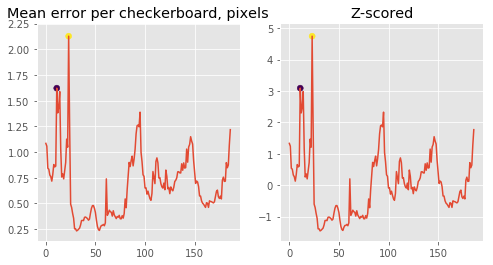

R: [[-0.002591  0.054852 -0.998491]
 [ 0.040935  0.997663  0.0547  ]
 [ 0.999158 -0.040731 -0.00483 ]]
t: [ 0.160357 -0.010522  0.112463]
Euler angles:  [-96.762868 -87.649263  93.621582]
RMSD: 0.000578


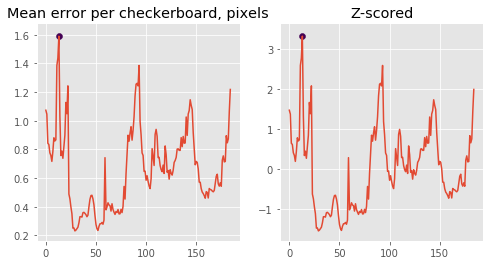

R: [[-0.00257   0.054804 -0.998494]
 [ 0.040963  0.997665  0.054653]
 [ 0.999157 -0.040761 -0.004809]]
t: [ 0.160356 -0.010517  0.112459]
Euler angles:  [-96.728331 -87.647696  93.589751]
RMSD: 0.000543


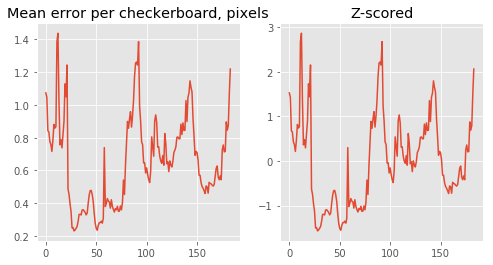

In [259]:
transformer = Transformer(calibdir, intrinsics, extrinsics, pairs)

In [260]:
transformer.R

{('right_ant', 'right_post'): array([[ 0.329863, -0.004465, -0.944018],
        [ 0.012936,  0.999916, -0.00021 ],
        [ 0.94394 , -0.012142,  0.329893]], dtype=float32),
 ('right_post', 'right_ant'): array([[ 0.329863,  0.012936,  0.94394 ],
        [-0.004465,  0.999916, -0.012142],
        [-0.944018, -0.00021 ,  0.329893]], dtype=float32),
 ('right_post', 'left_post'): array([[ 0.713173,  0.034658, -0.700131],
        [-0.048416,  0.998827,  0.000127],
        [ 0.699314,  0.033807,  0.714014]], dtype=float32),
 ('left_post', 'right_post'): array([[ 0.713173, -0.048416,  0.699314],
        [ 0.034658,  0.998827,  0.033807],
        [-0.700131,  0.000127,  0.714014]], dtype=float32),
 ('left_post', 'left_ant'): array([[-0.00257 ,  0.054804, -0.998494],
        [ 0.040963,  0.997665,  0.054653],
        [ 0.999157, -0.040761, -0.004809]], dtype=float32),
 ('left_ant', 'left_post'): array([[-0.00257 ,  0.040963,  0.999157],
        [ 0.054804,  0.997665, -0.040761],
        [-0.99

In [261]:
path = transformer.graph.find_shortest_path('right_ant', 'left_ant')
sequence = []
for i in range(len(path)-1):
    sequence.append((path[i], path[i+1]))

In [262]:
sequence

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [265]:
cams = tuple(cams)

In [267]:
cams = sequence[0]

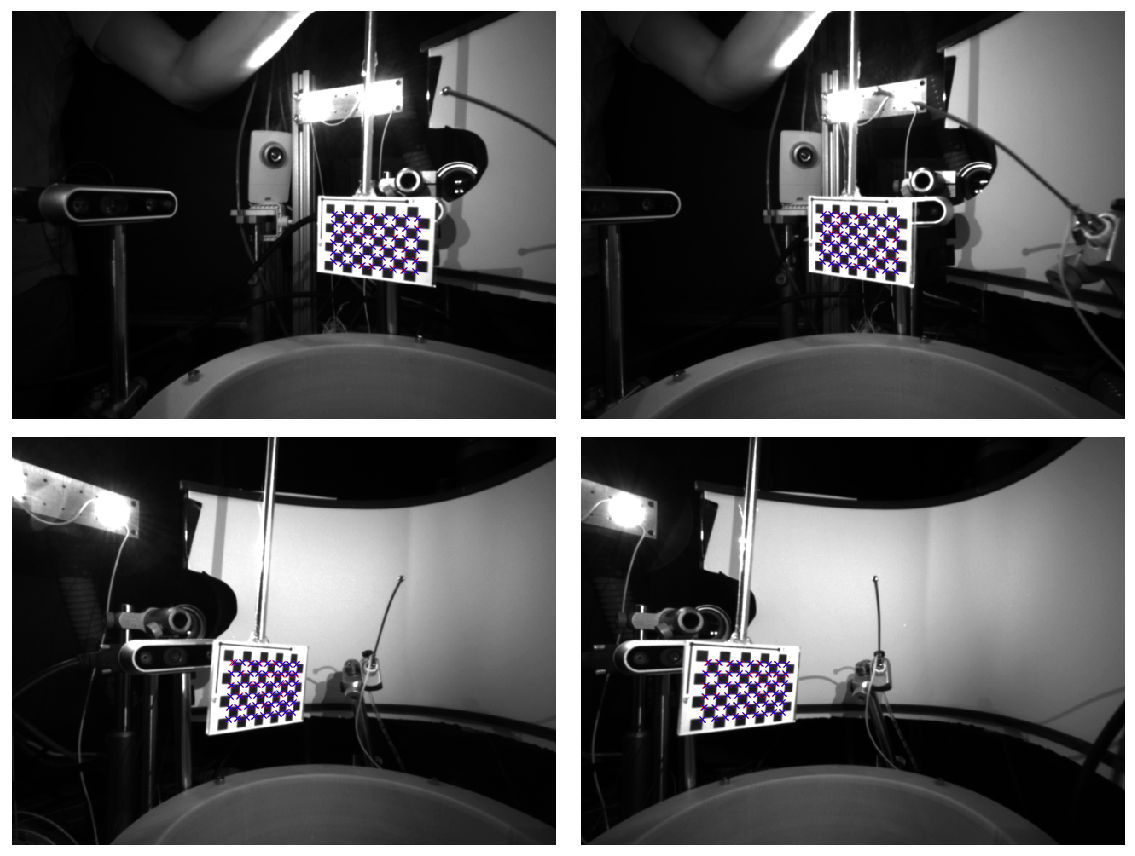

In [271]:
valid_indices = get_valid_camera_pairs(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source, target = clouds[cams[0]], clouds[cams[1]]

target_est = transformer.rs[cams].rotate(source)
source_est = transformer.rs[cams].rotate(target,target_to_source=True)

image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = transformer.rs[cams].reproject(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results


plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [272]:
transformer.R

{('right_ant', 'right_post'): array([[ 0.329863, -0.004465, -0.944018],
        [ 0.012936,  0.999916, -0.00021 ],
        [ 0.94394 , -0.012142,  0.329893]], dtype=float32),
 ('right_post', 'right_ant'): array([[ 0.329863,  0.012936,  0.94394 ],
        [-0.004465,  0.999916, -0.012142],
        [-0.944018, -0.00021 ,  0.329893]], dtype=float32),
 ('right_post', 'left_post'): array([[ 0.713173,  0.034658, -0.700131],
        [-0.048416,  0.998827,  0.000127],
        [ 0.699314,  0.033807,  0.714014]], dtype=float32),
 ('left_post', 'right_post'): array([[ 0.713173, -0.048416,  0.699314],
        [ 0.034658,  0.998827,  0.033807],
        [-0.700131,  0.000127,  0.714014]], dtype=float32),
 ('left_post', 'left_ant'): array([[-0.00257 ,  0.054804, -0.998494],
        [ 0.040963,  0.997665,  0.054653],
        [ 0.999157, -0.040761, -0.004809]], dtype=float32),
 ('left_ant', 'left_post'): array([[-0.00257 ,  0.040963,  0.999157],
        [ 0.054804,  0.997665, -0.040761],
        [-0.99

In [273]:
class Projector():
    def __init__(self, cams, P_l, P_r):
        # super().__init__()
        
        src_cam, tgt_cam = cams
        
        self.P_l_src = P_l[src_cam]
        self.P_r_src = P_r[src_cam]
        self.P_l_tgt = P_l[tgt_cam]
        self.P_r_tgt = P_r[tgt_cam]
        
    def append_ones(self, array):
        return(np.concatenate((array, np.ones((1, array.shape[1]), dtype=array.dtype)), axis=0))
    def project(self, x_3d,P):
        if x_3d is None:
            return(None)
        # print(x_3d.dtype)
        homogeneous = self.append_ones(x_3d)
        # print(homogeneous.shape)
        # print(P.shape)
        homogeneous = np.matmul(P, homogeneous)
        # print(homogeneous.shape)
        return(homogeneous[:2,:]/homogeneous[2,:])
    
    def __call__(self, source, target, source_est, target_est):
        source_l = self.project(source, self.P_l_src)
        source_est_l = self.project(source_est, self.P_l_src)
        source_r = self.project(source, self.P_r_src)
        source_est_r = self.project(source_est, self.P_r_src)
        
        target_l = self.project(target, self.P_l_tgt)
        target_est_l = self.project(target_est, self.P_l_tgt)
        target_r = self.project(target, self.P_r_tgt)
        target_est_r = self.project(target_est, self.P_r_tgt)
        
        return(source_l, source_est_l,
              source_r, source_est_r,
              target_l, target_est_l, 
              target_r, target_est_r)

In [274]:
def compose_transforms(R1, R2, t1, t2):
    R3 = R2 @ R1
    t3 = R2@t1 + t2
    return(R3,t3)

In [275]:
sequence

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [276]:
def compose(transformer, sequence):
    src, dest = sequence[0][0], sequence[1][1]
    R3, t3 = compose_transforms(transformer.R[sequence[0]], 
                                   transformer.R[sequence[1]],
                                   transformer.t[sequence[0]],
                                   transformer.t[sequence[1]])
    if len(sequence)==2:
        return(R3,t3)
    else:
        pair = (src,dest)
        sequence2 = sequence.copy()
        del(sequence2[0:2])
        sequence2.insert(0, pair)
        transformer.R[pair] = R3
        transformer.t[pair] = t3
        return(compose(transformer,sequence2))

In [277]:
cams = ('right_ant', 'left_post')

path = transformer.graph.find_shortest_path(cams[0],cams[1])
sequence = []
for i in range(len(path)-1):
    sequence.append((path[i], path[i+1]))

In [278]:
sequence

[('right_ant', 'right_post'), ('right_post', 'left_post')]

In [279]:
R3, t3 = compose(transformer, sequence)

In [280]:
cams = ('right_ant', 'left_post')

In [281]:
def get_indices_at_least_one_visible(calibdir, cams):
    h5file = os.path.join(calibdir, 'corners.h5')
    with h5py.File(h5file, 'r') as f:
        N = f[cams[0] + '/corners/l'].shape[0]

        all_valid = np.zeros((N,len(cams)), dtype=np.uint8)
        for i in range(len(cams)):
            l = f[cams[i] + '/corners/l'][:]
            r = f[cams[i] + '/corners/r'][:]
            # print(l)
            # print(r)
            # import pdb
            # pdb.set_trace()
            has_corners =  np.array([0 if np.any(np.isnan(j)) or np.any(np.isnan(k)) else 1 for j,k in zip(l,r)])
            all_valid[:,i] = has_corners
    valid_indices = np.where(all_valid.sum(axis=1)>0)[0]
    return(valid_indices)

In [282]:
plt.close('all')

In [284]:
%pdb

Automatic pdb calling has been turned OFF


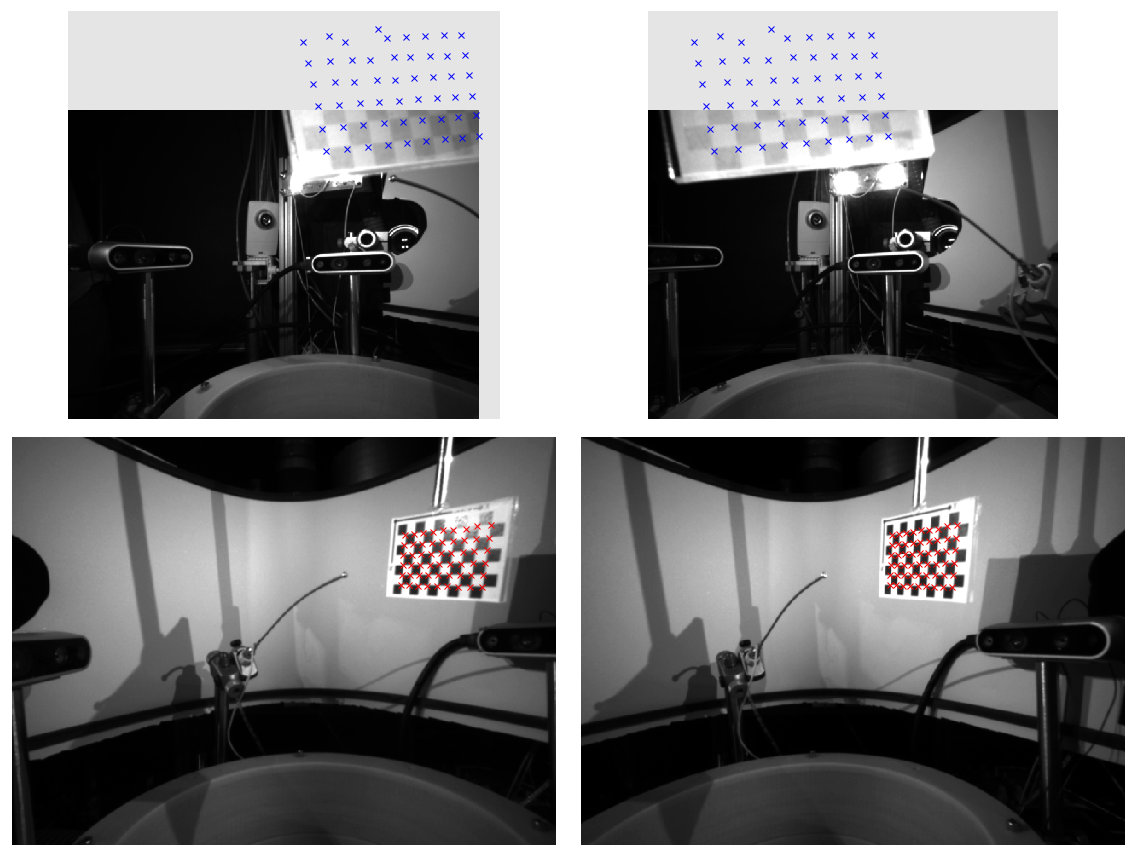

In [286]:
valid_indices = get_indices_at_least_one_visible(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
projector = Projector(cams, P_l, P_r)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source = clouds[cams[0]]
target = clouds[cams[1]]

# tar

if source is not None:
    target_est = R3 @ source + t3
else:
    target_est = None
# source_est = transformer.rs[cams].rotate(target,target_to_source=True)
R3_inv, t3_inv = invert_transform(R3,t3)
if target is not None:
    source_est = R3_inv @ target + t3_inv
else:
    source_est = None

if source is not None:
    target_est = transformer.transform(source, cams[0], cams[1])
if target is not None:
    source_est = transformer.transform(target, cams[1], cams[0])
    

image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = projector(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

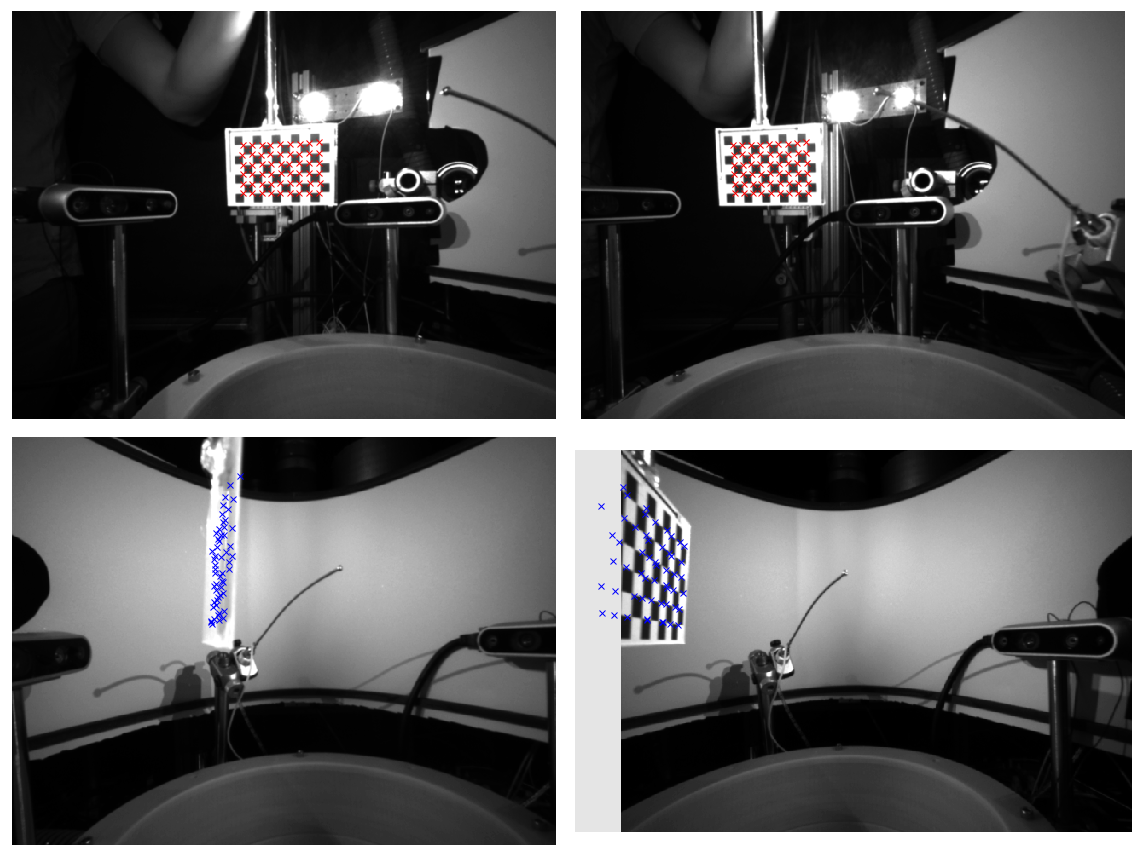

In [289]:
valid_indices = get_indices_at_least_one_visible(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source, target = clouds[cams[0]], clouds[cams[1]]

if source is not None:
    target_est = R3 @ source + t3
else:
    target_est = None
# source_est = transformer.rs[cams].rotate(target,target_to_source=True)
R3_inv, t3_inv = invert_transform(R3,t3)
if target is not None:
    source_est = R3_inv @ target + t3_inv
else:
    source_est = None


image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = projector(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

# Visualizing all images with at least one checkerboard detected

In [290]:
cams = ['left_ant', 'left_post', 'right_ant', 'right_post']
# cams = ['right_ant', 'right_post']
valid_indices = get_indices_at_least_one_visible(calibdir, cams)

~~~ Calibrating pair:  ('right_ant', 'right_post') ~~~
R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


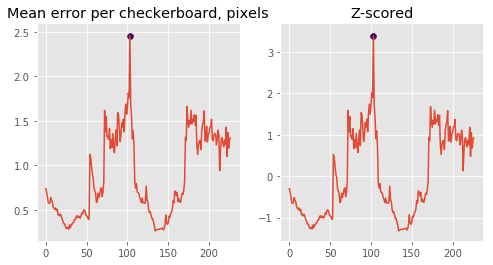

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


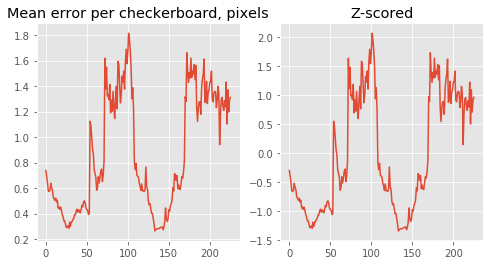

~~~ Calibrating pair:  ('right_post', 'left_post') ~~~
R: [[ 0.713329  0.034569 -0.699976]
 [-0.048291  0.998833  0.000117]
 [ 0.699164  0.033719  0.714166]]
t: [ 0.110353 -0.00463   0.019609]
Euler angles:  [  2.703221 -44.359943  -3.872908]
RMSD: 0.000423


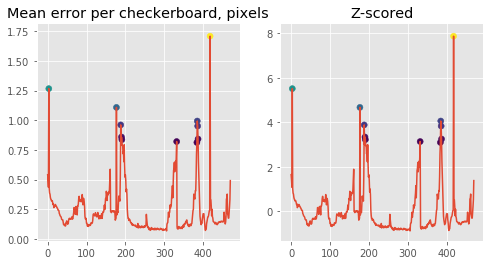

R: [[ 0.713241  0.034609 -0.700064]
 [-0.048346  0.998831  0.000123]
 [ 0.699249  0.033757  0.714081]]
t: [ 0.110373 -0.004627  0.019613]
Euler angles:  [  2.706569 -44.366802  -3.877773]
RMSD: 0.000325


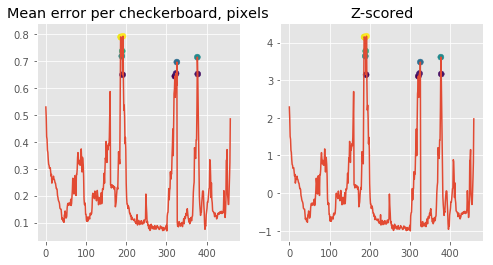

R: [[ 0.713171  0.034681 -0.700131]
 [-0.048422  0.998827  0.000153]
 [ 0.699315  0.033793  0.714014]]
t: [ 0.11039  -0.004624  0.019615]
Euler angles:  [  2.709646 -44.3721    -3.884234]
RMSD: 0.000260


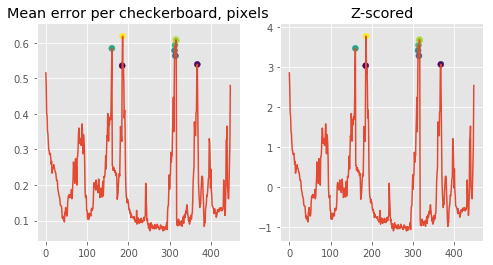

R: [[ 0.713151  0.034682 -0.700152]
 [-0.048432  0.998826  0.000146]
 [ 0.699335  0.033806  0.713994]]
t: [ 0.110395 -0.004622  0.019616]
Euler angles:  [  2.710778 -44.373687  -3.88516 ]
RMSD: 0.000237


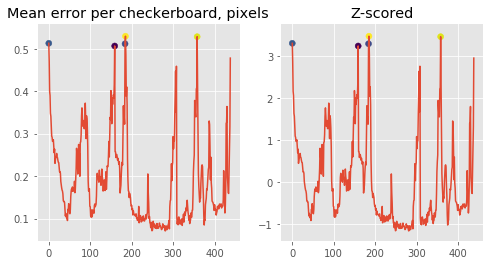

R: [[ 0.713173  0.034658 -0.700131]
 [-0.048416  0.998827  0.000127]
 [ 0.699314  0.033807  0.714014]]
t: [ 0.110391 -0.004621  0.019614]
Euler angles:  [  2.710816 -44.372028  -3.883733]
RMSD: 0.000227


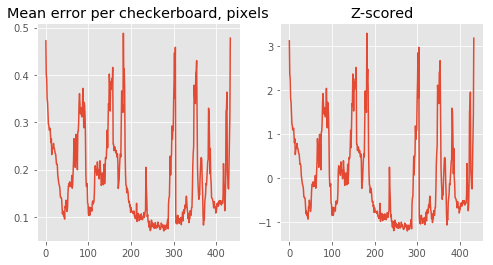

~~~ Calibrating pair:  ('left_post', 'left_ant') ~~~
R: [[-0.002489  0.054955 -0.998486]
 [ 0.041163  0.997648  0.054807]
 [ 0.999149 -0.040964 -0.004745]]
t: [ 0.160355 -0.01055   0.112451]
Euler angles:  [-96.607829 -87.636566  93.46043 ]
RMSD: 0.000626


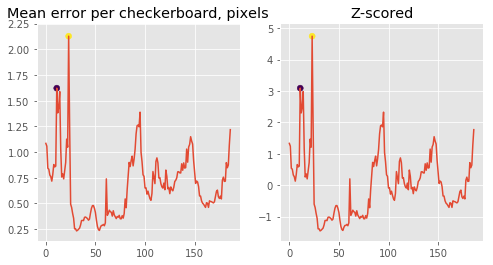

R: [[-0.002591  0.054852 -0.998491]
 [ 0.040935  0.997663  0.0547  ]
 [ 0.999158 -0.040731 -0.00483 ]]
t: [ 0.160357 -0.010522  0.112463]
Euler angles:  [-96.762868 -87.649263  93.621582]
RMSD: 0.000578


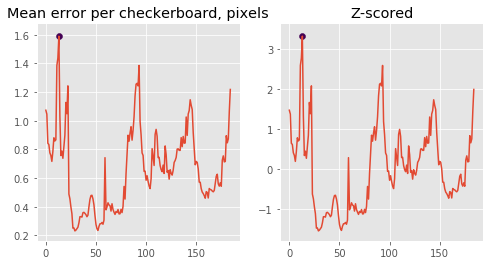

R: [[-0.00257   0.054804 -0.998494]
 [ 0.040963  0.997665  0.054653]
 [ 0.999157 -0.040761 -0.004809]]
t: [ 0.160356 -0.010517  0.112459]
Euler angles:  [-96.728331 -87.647696  93.589751]
RMSD: 0.000543


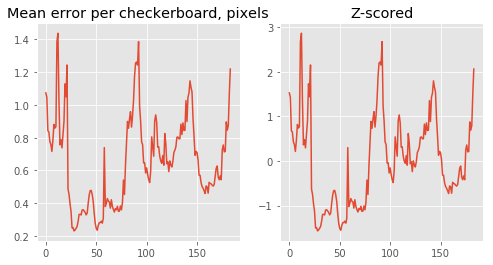

In [291]:
transformer = Transformer(calibdir, intrinsics, extrinsics, pairs)

In [292]:
dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)

In [295]:
%matplotlib qt5

In [296]:
ind = np.random.randint(low=0, high=len(dataset))
clouds = dataset[ind]


plt.close('all')
for key,value in clouds.items():
    if value is not None:
        source_cam =key

lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, valid_indices[ind])

fig, axes = plt.subplots(2,4,figsize=(16,10))

cam = cams[0]
color = 'r' if cam == source_cam else 'b'
ax = axes[0,0]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
# plot_corners(source_l, ax, text=plot_text)
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[0,1]
ax.imshow(rights[cam], 'gray')
# plot_corners(source_r, ax, text=plot_text)
plot_corners(target_est_r, ax, text=plot_text, color=color)


cam = cams[1]
color = 'r' if cam == source_cam else 'b'
ax = axes[0,2]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[0,3]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)



cam = cams[2]
color = 'r' if cam == source_cam else 'b'
ax = axes[1,0]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[1,1]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)


cam = cams[3]
color = 'r' if cam == source_cam else 'b'
ax = axes[1,2]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[1,3]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)


plt.tight_layout()
plt.show()